![Bildschirmfoto 2024-06-28 um 14.59.25.png](<attachment:Bildschirmfoto 2024-06-28 um 14.59.25.png>)
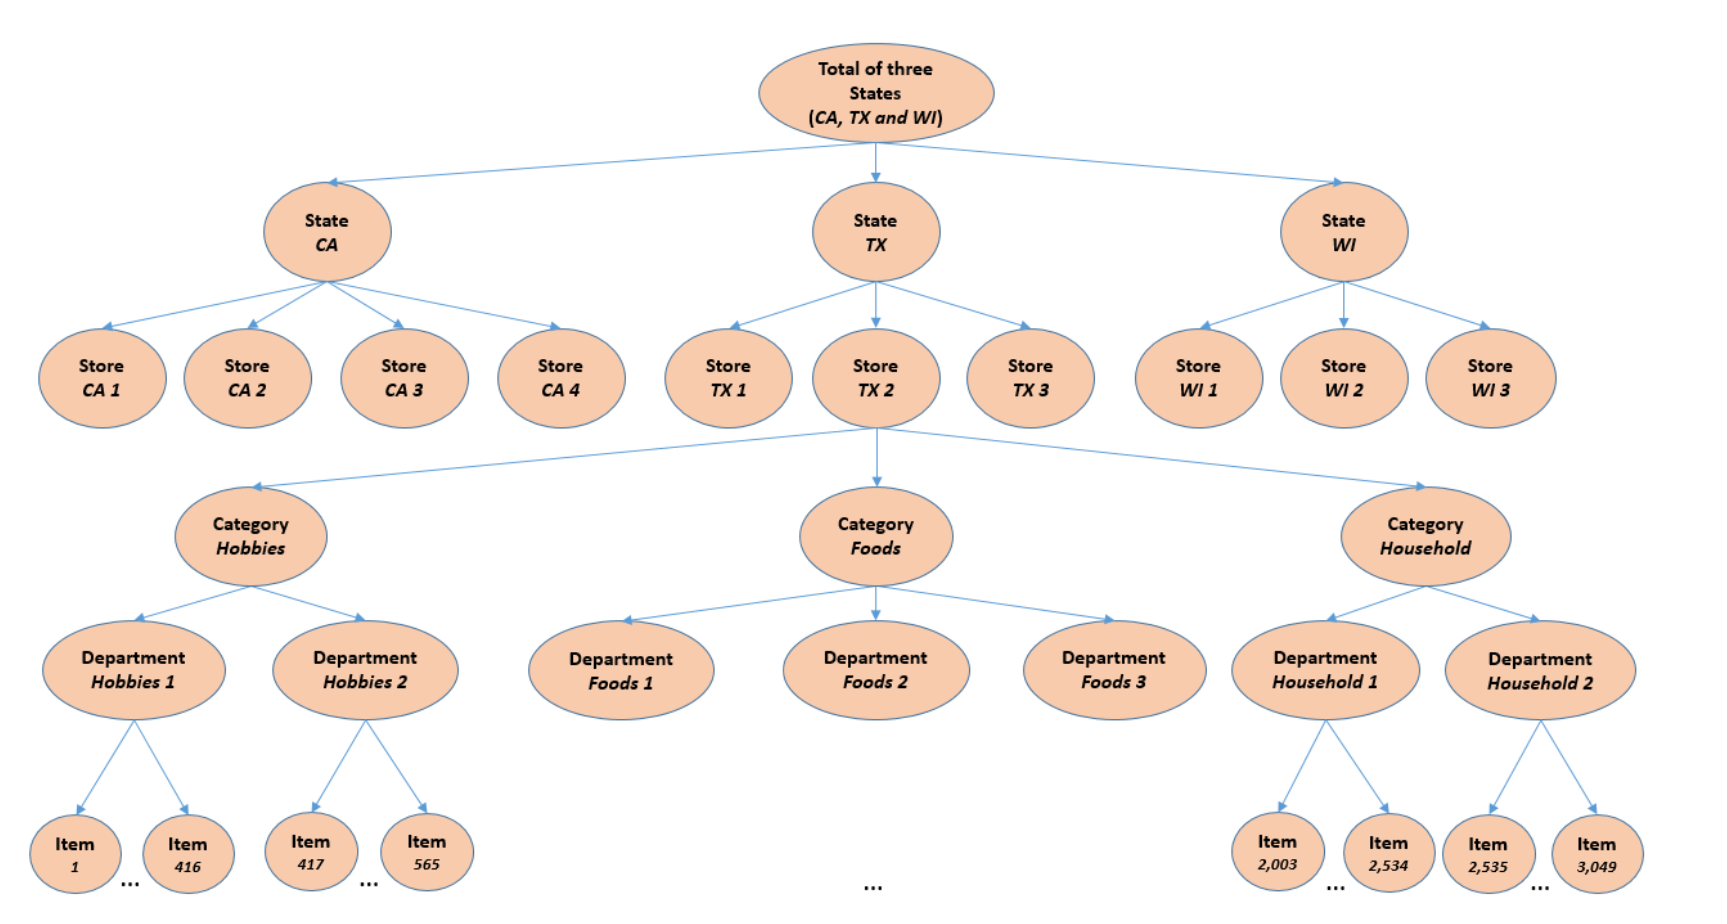

## Import Packages and create helpful functions

In [42]:

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import openpyxl
import time 


# # Deep learning packages
import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, TimeLLM,  NHITS, NBEATS, Informer, TFT , NBEATSx, PatchTST, TimesNet, TimeMixer
from neuralforecast.losses.pytorch import DistributionLoss

from neuralforecast.auto import AutoNHITS, AutoLSTM, AutoInformer, AutoNBEATS, AutoPatchTST, AutoTimesNet, AutoTimeMixer
from neuralforecast.losses.pytorch import RMSE as torch_rmse
from neuralforecast.losses.pytorch import MAE as torch_mae

#from transformers import GPT2Config, GPT2Model, GPT2Tokenizer


# Hierarchical packages
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import  BottomUp, TopDown, MiddleOut, MinTrace, ERM, OptimalCombination

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, SeasonalRollingMean, RollingStd, RollingMax, RollingMin, RollingQuantile
from mlforecast.target_transforms import Differences

from optuna.samplers import TPESampler
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import pandas as pd
from xgboost import XGBRegressor



import numpy as np

# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
# from statsmodels.tsa.statespace.sarimax import SARIMAX


from hierarchicalforecast.evaluation import HierarchicalEvaluation
from mlforecast.core import DateFeature
from mlforecast.utils import PredictionIntervals
from utilsforecast.plotting import plot_series

#from datasetsforecast.hierarchical import HierarchicalData

from statsforecast.core import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, HistoricAverage, RandomWalkWithDrift, SeasonalNaive, HoltWinters, ARIMA
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from tqdm.autonotebook import tqdm
# from sklearn.metrics import mean_squared_error as mse

import pickle

import optuna
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
#from tqdm import tqdm
from utilsforecast.losses import mase, rmse
from utilsforecast.plotting import plot_series


In [43]:
import pkg_resources

packages = [
    "matplotlib", "seaborn", "statsmodels", "openpyxl", "time", 
    "torch", "neuralforecast", "transformers", "hierarchicalforecast", 
    "mlforecast", "optuna", "lightgbm", "sklearn", "pandas", 
    "xgboost", "numpy", "utilsforecast", "tqdm"
]

for package in packages:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package}: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package}: Not installed")


matplotlib: 3.8.4
seaborn: 0.13.2
statsmodels: 0.14.2
openpyxl: 3.1.2
time: Not installed
torch: 2.2.2
neuralforecast: 1.7.4
transformers: 4.44.0
hierarchicalforecast: 0.2.1
mlforecast: 0.13.3
optuna: 3.6.1
lightgbm: 4.5.0
sklearn: Not installed
pandas: 2.2.2
xgboost: 2.1.1
numpy: 1.26.4
utilsforecast: 0.2.2
tqdm: 4.66.4


In [44]:
# import pkg_resources

# with open("M5_requirments.txt", "w") as file:
#     for package in packages:
#         try:
#             version = pkg_resources.get_distribution(package).version
#             file.write(f"{package}: {version}\n")
#         except pkg_resources.DistributionNotFound:
#             file.write(f"{package}: Not installed\n")


In [45]:
# Evaluation metrics
def MSE(y_true, y_hat):
    return np.mean((y_true-y_hat)**2)

def RMSE(y_true, y_hat):
    return round(np.mean(np.sqrt(np.mean((y_true-y_hat)**2, axis=1))), 2)

def MAE(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))  

def MAPE(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return round(np.mean(np.abs((y_true - y_pred) / y_true)), 4)   

def MASE(y, y_hat, y_insample, seasonality=4):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return round(np.mean(errors / scale), 4)

    
# def MAPE(y, y_hat):
#     return np.mean(np.abs(y-y_hat)/y)

def rmse(y_true, y_hat):
    return round(np.mean(np.sqrt(np.mean((y_true-y_hat)**2))), 2)

In [46]:

plt.style.use('seaborn-v0_8-whitegrid')
dark_style = {
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.linewidth': '1',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


## Import the prepared data

In [14]:
calendar = pd.read_csv('data/M5/calendar.csv')
calendar_df = calendar.loc[:, ['date', 'wm_yr_wk', 'd']]

In [15]:
#df = pd.read_hdf('CAL_Stores_melted.h5', key='df')
# df = pd.read_csv('data/ready/melted_data.csv')

In [16]:
# df = pd.read_csv('data/M5/sales_train_validation.csv')
# calendar_df = calendar.loc[:, ['date', 'wm_yr_wk', 'd']]
# df_T = df.melt(id_vars=['dept_id', 'cat_id', 'store_id', 'state_id'])
# #df_T.drop(columns=['id'], inplace=True)
# df_T = df_T.merge(calendar_df, left_on='variable', right_on='d')
# df_T.drop(columns=['d', 'variable', 'wm_yr_wk'], inplace=True)
# df_T.insert(4, "country", "USA")
# df_T.rename(columns={'value': 'y', 'date': 'ds'}, inplace=True)
# df_T['ds'] = pd.to_datetime(df_T['ds'])
# df_T

In [17]:
# #df_T.to_hdf('data/ready/melted_data_final.parquet', key='df', mode='w')
# df = pd.read_hdf('data/ready/melted_data_final.parquet', key='df')

In [18]:
# spec = [['country'], 
#         ['country', 'state_id'], 
#         ['country', 'state_id', "store_id"], 
#         ['country', 'state_id', "store_id", "cat_id"], 
#         ['country', 'state_id', "store_id", "cat_id", "dept_id"]]

# Y_df, S_df, tags = aggregate(df, spec)
# Y_df = Y_df.reset_index()
# Y_df.head(20)

In [19]:
# Y_df.to_csv('data/ready/Y_df.csv', index=False)
# S_df.to_csv('data/ready/S_df.csv', index=True, index_label='unique_id')
# pickle.dump(tags, open('data/ready/tags.pkl', 'wb'))


In [20]:
Y_df = pd.read_csv('data/M5/Y_df.csv')
S_df = pd.read_csv('data/M5/S_df.csv')
S_df = S_df.set_index('unique_id')
tags = pickle.load(open('data/M5/tags.pkl', 'rb'))


In [21]:
# tags = pickle.load(open('tags.pkl', 'rb'))
# S_df = pd.read_csv('data/Ready/S_df_all_states.csv').rename(columns={'Unnamed: 0': ''})
# S_df.set_index('', inplace=True)
# Y_df = pd.read_csv('data/Ready/Y_df_all_states.csv')

In [23]:
event_days = calendar[['date', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2']].copy()
event_days.rename(columns={'date': 'ds'}, inplace=True)

snap_ca = calendar[['date', 'snap_CA']].copy()
snap_ca.rename(columns={'date': 'ds', 'snap_CA': 'snap_ca'}, inplace=True)

holidays_df = event_days.merge(snap_ca, on='ds')
#holidays_df["ds"] = pd.to_datetime(holidays_df["ds"])

In [24]:
holidays_df['Holiday'] = 0
holidays_df.loc[holidays_df['event_name_1'].notnull(), 'Holiday'] = 1
holidays_df.loc[holidays_df['event_name_2'].notnull(), 'Holiday'] = 1
#holidays_df['ds'] = pd.to_datetime(holidays_df['ds'])

In [25]:
Y_df_full = Y_df.merge(holidays_df, on='ds', how='left')
#Y_df_full = pd.concat([Y_df, holidays_df])
Y_df_full

unique_id          ds      y event_name_1  \
0                                     USA  2011-01-29  32631          NaN   
1                                     USA  2011-01-30  31749          NaN   
2                                     USA  2011-01-31  23783          NaN   
3                                     USA  2011-02-01  25412          NaN   
4                                     USA  2011-02-02  19146          NaN   
...                                   ...         ...    ...          ...   
218077  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-20    148          NaN   
218078  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-21    142          NaN   
218079  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-22    166          NaN   
218080  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-23    232          NaN   
218081  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-24    201          NaN   

       event_name_2 event_type_1 event_type_2  snap_ca  Holiday  
0               NaN          NaN          NaN        0        0  
1               NaN          NaN          NaN        0        0  
2               NaN          NaN          NaN        0        0  
3               NaN          NaN          NaN        1        0  
4               NaN          NaN          NaN        1        0  
...             ...          ...          ...      ...      ...  
218077          NaN          NaN          NaN        0        0  
218078          NaN          NaN          NaN        0        0  
218079          NaN          NaN          NaN        0        0  
218080          NaN          NaN          NaN        0        0  
218081          NaN          NaN          NaN        0        0  

[218082 rows x 9 columns]

## Explorative Data Analytics

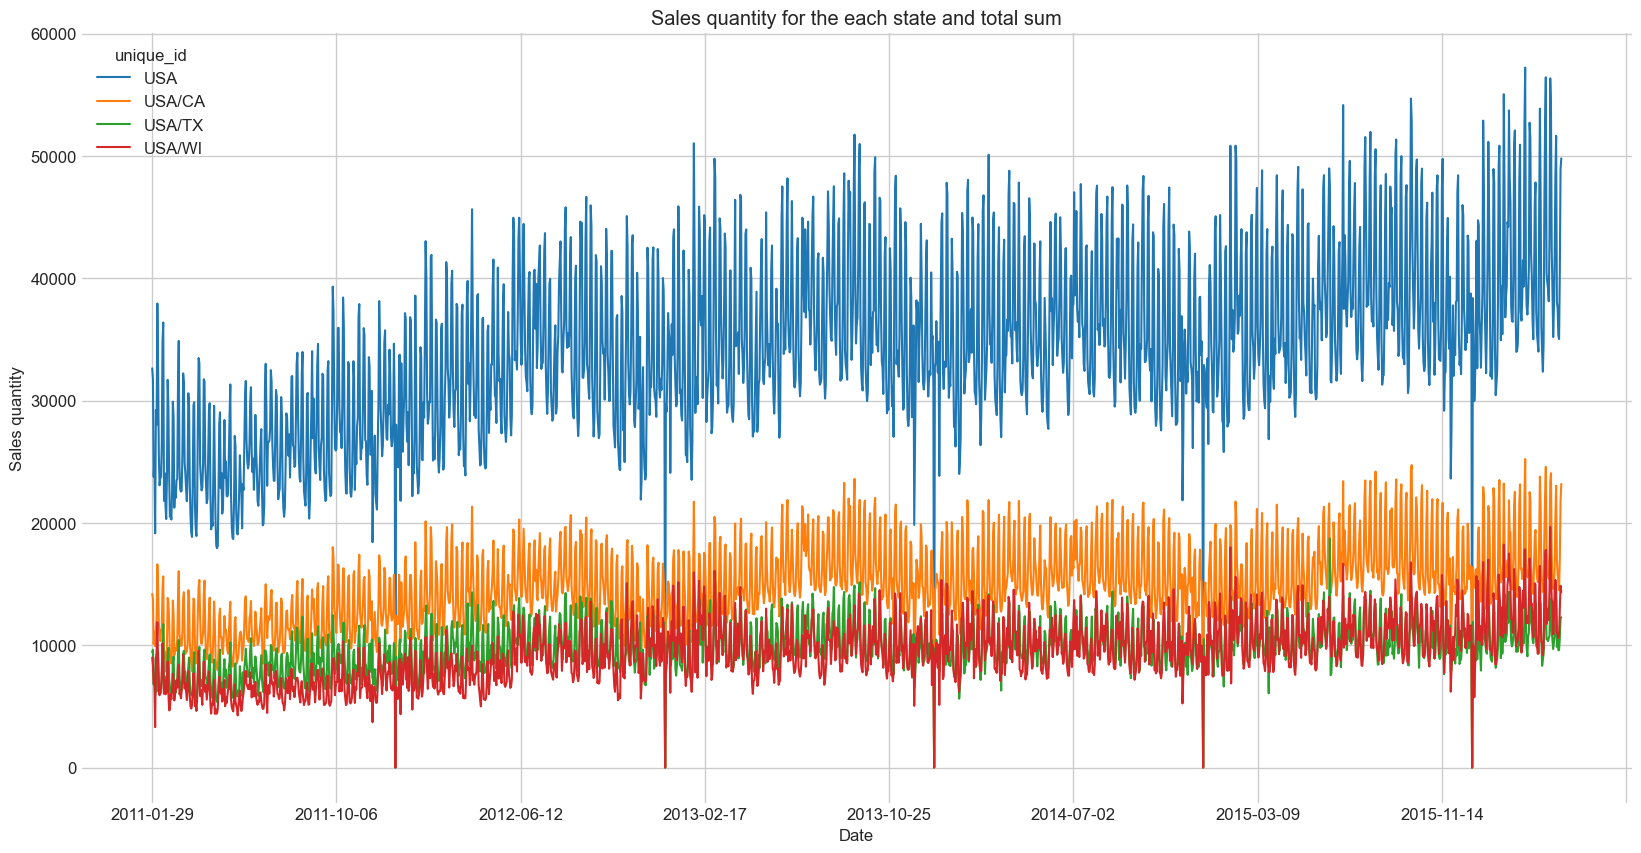

In [26]:
Y_states = Y_df_full[Y_df_full['unique_id'].str.startswith('USA')]
cols = Y_states['unique_id'].unique()[:4].tolist()
Y_states.groupby(['ds', 'unique_id'])['y'].sum().unstack().loc[:, cols].plot(figsize=(20, 10))
plt.title('Sales quantity for the each state and total sum')
plt.xlabel('Date')
plt.ylabel('Sales quantity')
plt.show()

c:\Users\49152\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


ADF Statistic: -1.5653733253318465
p-value: 0.5009604361797745
Critical Value (1%): -3.434
Critical Value (5%): -2.863
Critical Value (10%): -2.568
The time series is likely non-stationary.


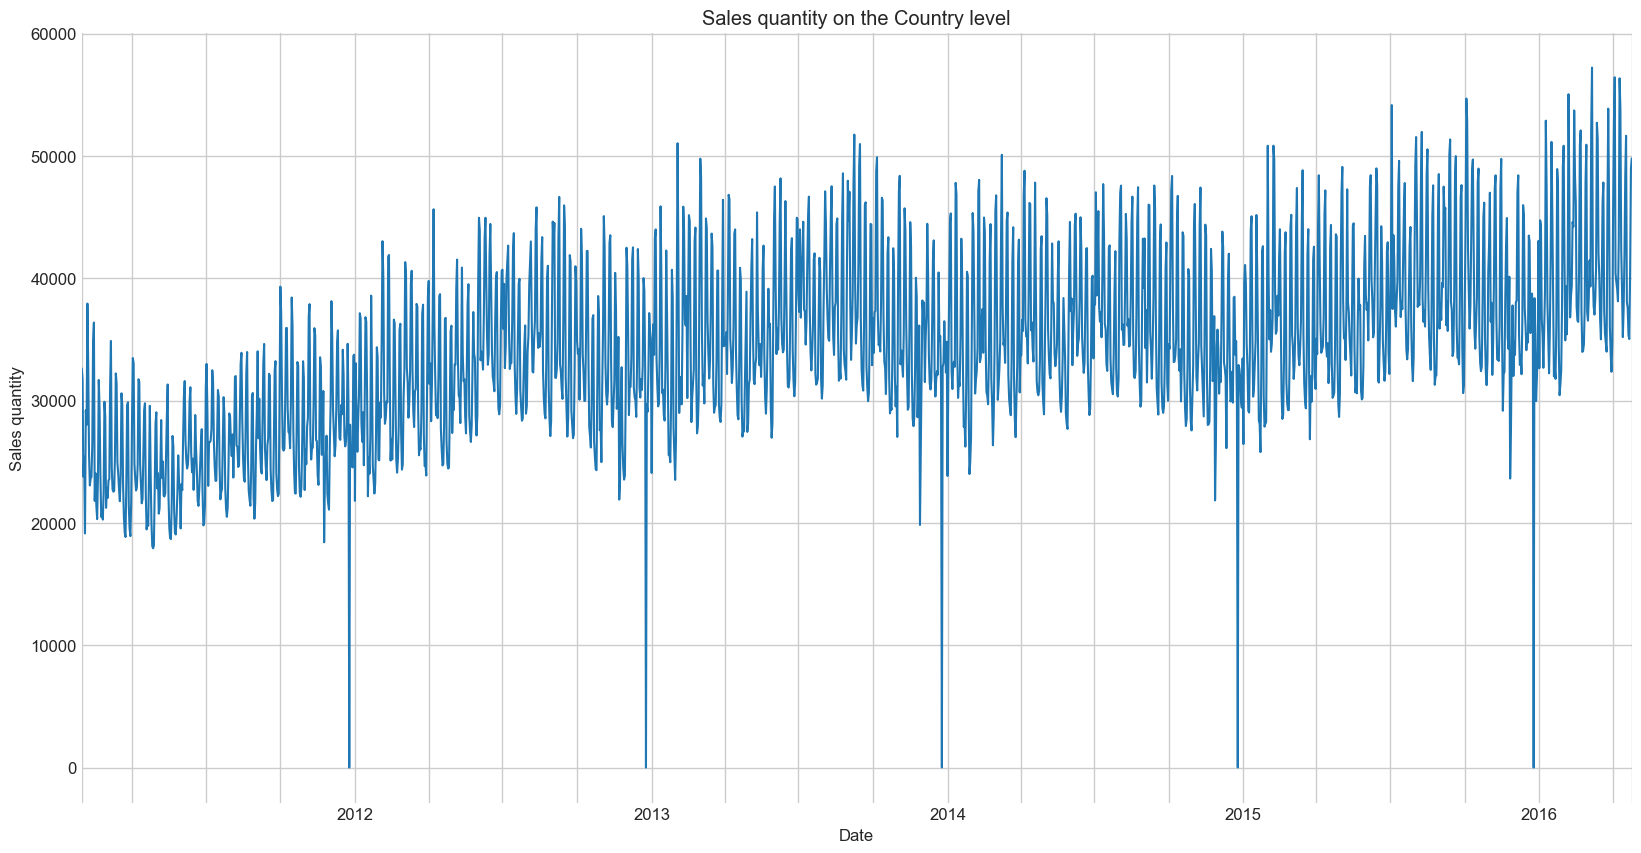

In [27]:
from statsmodels.tsa.stattools import adfuller

total_sales = Y_states[Y_states['unique_id']=='USA'] 
total_sales.loc[:, ('ds')] = pd.to_datetime(total_sales['ds'], errors='coerce')
total_sales.set_index('ds', inplace=True)
result = adfuller(total_sales['y'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

# Interpretation
if result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

total_sales['y'].plot(figsize=(20, 10))    
plt.title('Sales quantity on the Country level')
plt.xlabel('Date')
plt.ylabel('Sales quantity')
plt.show()

ADF Statistic: -21.338292314725166
p-value: 0.0
Critical Value (1%): -3.434
Critical Value (5%): -2.863
Critical Value (10%): -2.568
The time series is likely stationary.


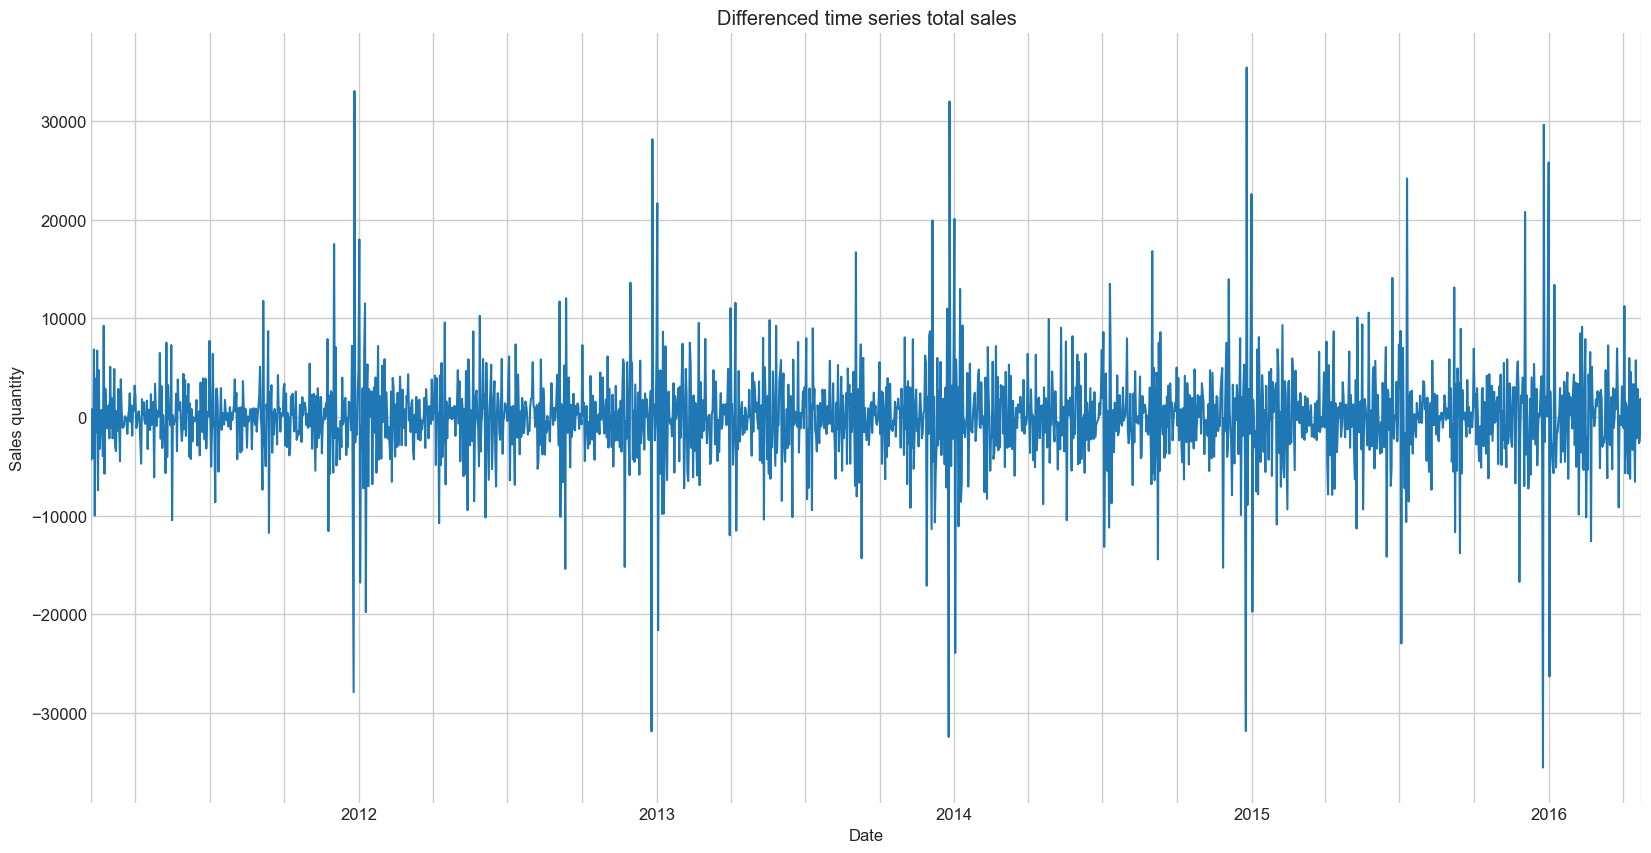

In [28]:
total_diff = total_sales['y'].diff(1).diff(7).dropna()
result = adfuller(total_diff)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

# Interpretation
if result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

total_diff.plot(figsize=(20, 10))
plt.title('Differenced time series total sales')
plt.xlabel('Date')
plt.ylabel('Sales quantity')
plt.show()    

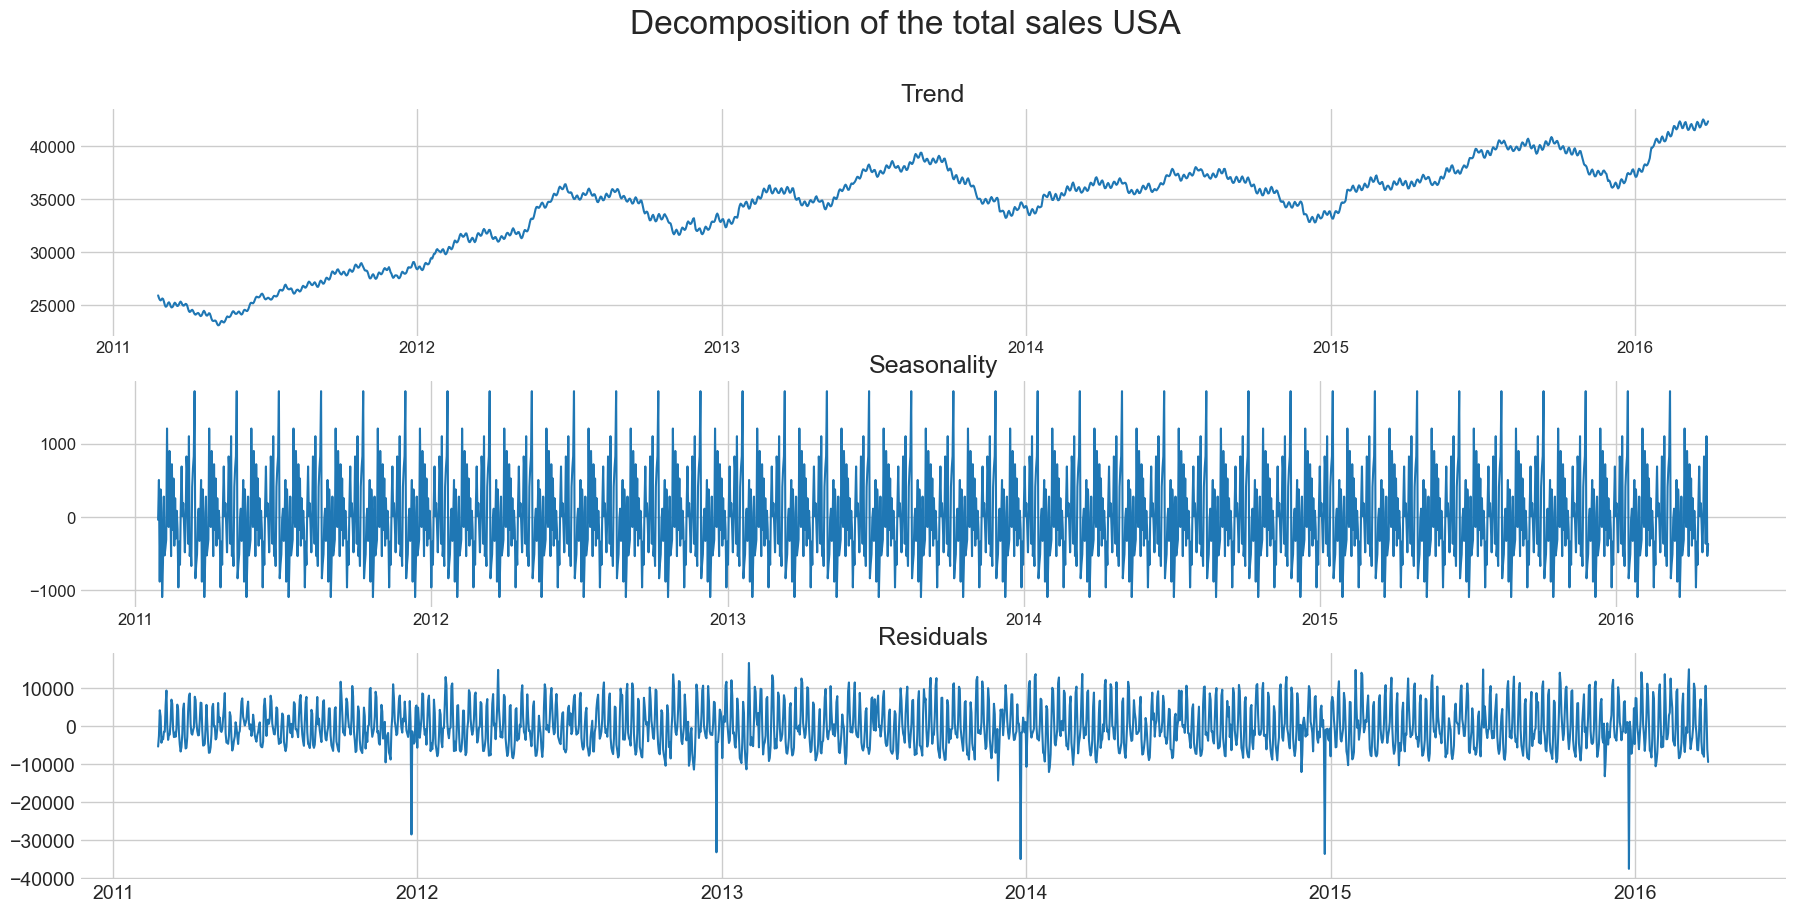

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert the 'ds' column to datetime

# Set 'ds' column as the index
#CA_df = Y_states[Y_states['unique_id']=='USA/CA'] 

#CA_df.set_index('ds', inplace=True)
# Perform time series decomposition
decomposition = seasonal_decompose(total_sales['y'], model='additive', period=52)

# Plot the decomposition

trend     = decomposition.trend.infer_objects()
seasonal  = decomposition.seasonal.infer_objects()
residuals = decomposition.resid.infer_objects()
# plot every component
plt.figure(figsize=(22,10))
plt.subplot(311)
plt.plot(trend)
plt.suptitle('Decomposition of the total sales USA', fontsize=24)
plt.title('Trend', fontsize=18)
plt.subplot(312)
plt.plot(seasonal)
plt.title('Seasonality', fontsize=18)
plt.subplot(313)
plt.plot(residuals)
plt.title('Residuals', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Relevance of holidays

In [32]:
def holiday_viz(df, criteria):
    #df['ds']= df['ds'].astype('str')
    #df = df.set_index('ds')
    fig, ax = plt.subplots(figsize=(24, 10))
    col = criteria
    df2 = df.copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df.set_index('ds', inplace=True)
    ax.vlines(
        x=df.index,
        ymin=0,
        ymax=df['sales'],
        linewidth=0.5,
        color='grey',
        label='Actual Sales',
        zorder=1)

    ax.vlines(
        x=df[df[col]==1].index,
        ymin=0,
        ymax=df.loc[df[col]==1, 'sales'],
        color='red',
        linewidth=1,
        zorder=2)
    
    ax.vlines(
        x=df[df["Holiday"]==1].index,
        ymin=0,
        ymax=df.loc[df["Holiday"]==1, 'sales'],
        color='green',
        linewidth=1,
        label='Evenet Day',
        zorder=4)

    ax.scatter(
        x=df[df[col]==1].index,
        y=df.loc[df[col]==1, 'sales'],
        color='red',
        s=3,
        label='Sales on Events',
        zorder=2)

    ax.plot(
         df['MA7'],
        color='black',
        linewidth=0.75,
        label='Sales MA (7 days)',
        linestyle='dashed',
        zorder=3)

    ax.set_title('Holiday related sales above the weekly moving average (Last 365 days)', fontsize=22)
    ax.set_ylabel('Sales', fontsize=18)
    ax.set_xlabel('Date', fontsize=18)
    ax.legend(loc='upper right',  ncol=4, fontsize=18, frameon=False)
    ax.tick_params(axis='both', labelsize=14) 

    ax.margins(x=0.005)
    df.reset_index(inplace=True)



In [33]:
df = Y_df_full.copy()
df['MA7'] = round(df['y'].rolling(window=7).mean(), 0) 
#df =  df.dropna(subset='MA7', axis=0)

df.rename(columns={'y': 'sales'}, inplace=True)
holiday_indices = df.index[df['event_name_1'].notna() | df['event_name_2'].notna()]

# Initialize the Holiday_related column with zeros
df['Holiday_related'] = 0

# Create a mask for the 7 days before and after each holiday
for index in holiday_indices:
    start_idx = max(0, index - 7)
    end_idx = min(len(df), index + 1)  # Exclusive of the end
    # Set Holiday_related to 1 if sales are above moving average
    df.loc[start_idx:end_idx, 'Holiday_related'] = (
        (df.loc[start_idx:end_idx, 'sales'] > df.loc[start_idx:end_idx, 'MA7']).astype(int)
    )

# Display the updated DataFrame
df.head(15)

unique_id          ds  sales event_name_1 event_name_2 event_type_1  \
0        USA  2011-01-29  32631          NaN          NaN          NaN   
1        USA  2011-01-30  31749          NaN          NaN          NaN   
2        USA  2011-01-31  23783          NaN          NaN          NaN   
3        USA  2011-02-01  25412          NaN          NaN          NaN   
4        USA  2011-02-02  19146          NaN          NaN          NaN   
5        USA  2011-02-03  29211          NaN          NaN          NaN   
6        USA  2011-02-04  28010          NaN          NaN          NaN   
7        USA  2011-02-05  37932          NaN          NaN          NaN   
8        USA  2011-02-06  32736    SuperBowl          NaN     Sporting   
9        USA  2011-02-07  25572          NaN          NaN          NaN   
10       USA  2011-02-08  23071          NaN          NaN          NaN   
11       USA  2011-02-09  23658          NaN          NaN          NaN   
12       USA  2011-02-10  23756          NaN          NaN          NaN   
13       USA  2011-02-11  26445          NaN          NaN          NaN   
14       USA  2011-02-12  34833          NaN          NaN          NaN   

   event_type_2  snap_ca  Holiday      MA7  Holiday_related  
0           NaN        0        0      NaN                0  
1           NaN        0        0      NaN                0  
2           NaN        0        0      NaN                0  
3           NaN        1        0      NaN                0  
4           NaN        1        0      NaN                0  
5           NaN        1        0      NaN                0  
6           NaN        1        0  27135.0                1  
7           NaN        1        0  27892.0                1  
8           NaN        1        1  28033.0                1  
9           NaN        1        0  28288.0                0  
10          NaN        1        0  27954.0                0  
11          NaN        1        0  28599.0                0  
12          NaN        1        0  27819.0                0  
13          NaN        0        0  27596.0                0  
14          NaN        0        0  27153.0                1

In [34]:
# incorrect_sales = df[(df['Holiday_related'] == 1) & (df['sales'] <= df['MA7'])]
# assert incorrect_sales.empty
#df.to_csv('data/Ready/df_holidays.csv', index=False)
df = pd.read_csv('data/Ready/df_7days.csv')

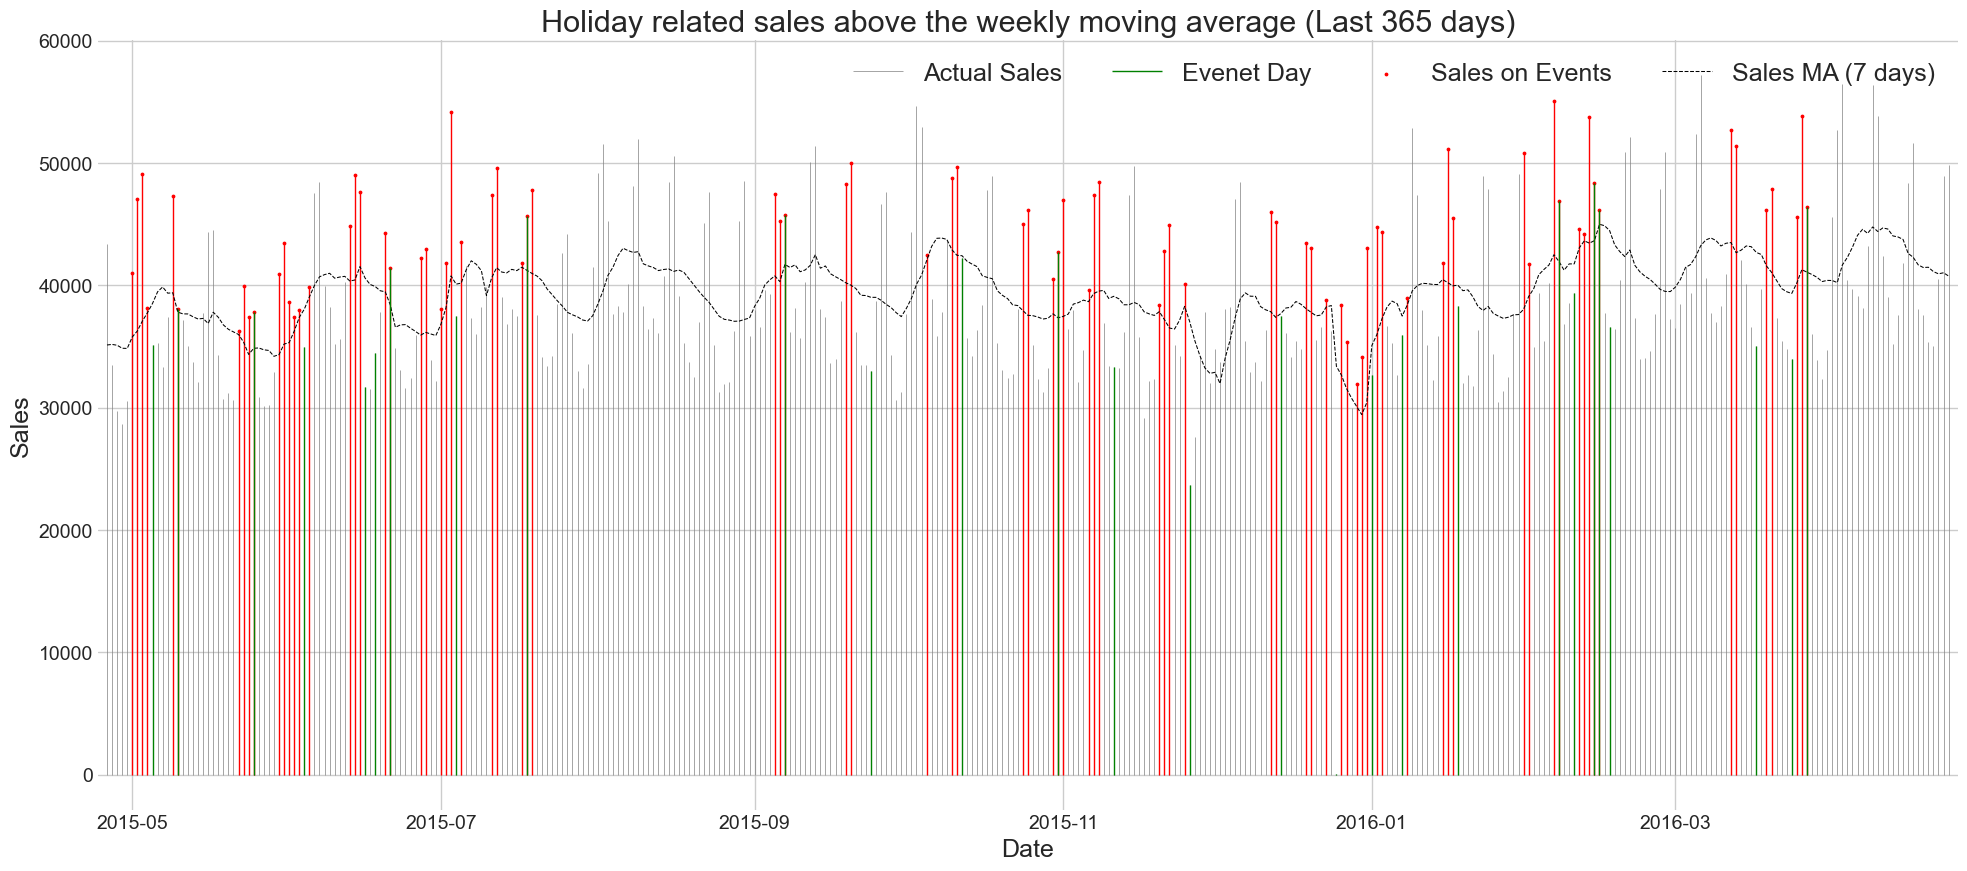

In [35]:
daily_viz = df[df['unique_id'] == 'USA'].tail(365).drop(columns=['unique_id'])

holiday_viz(df= daily_viz, criteria='Holiday_related')


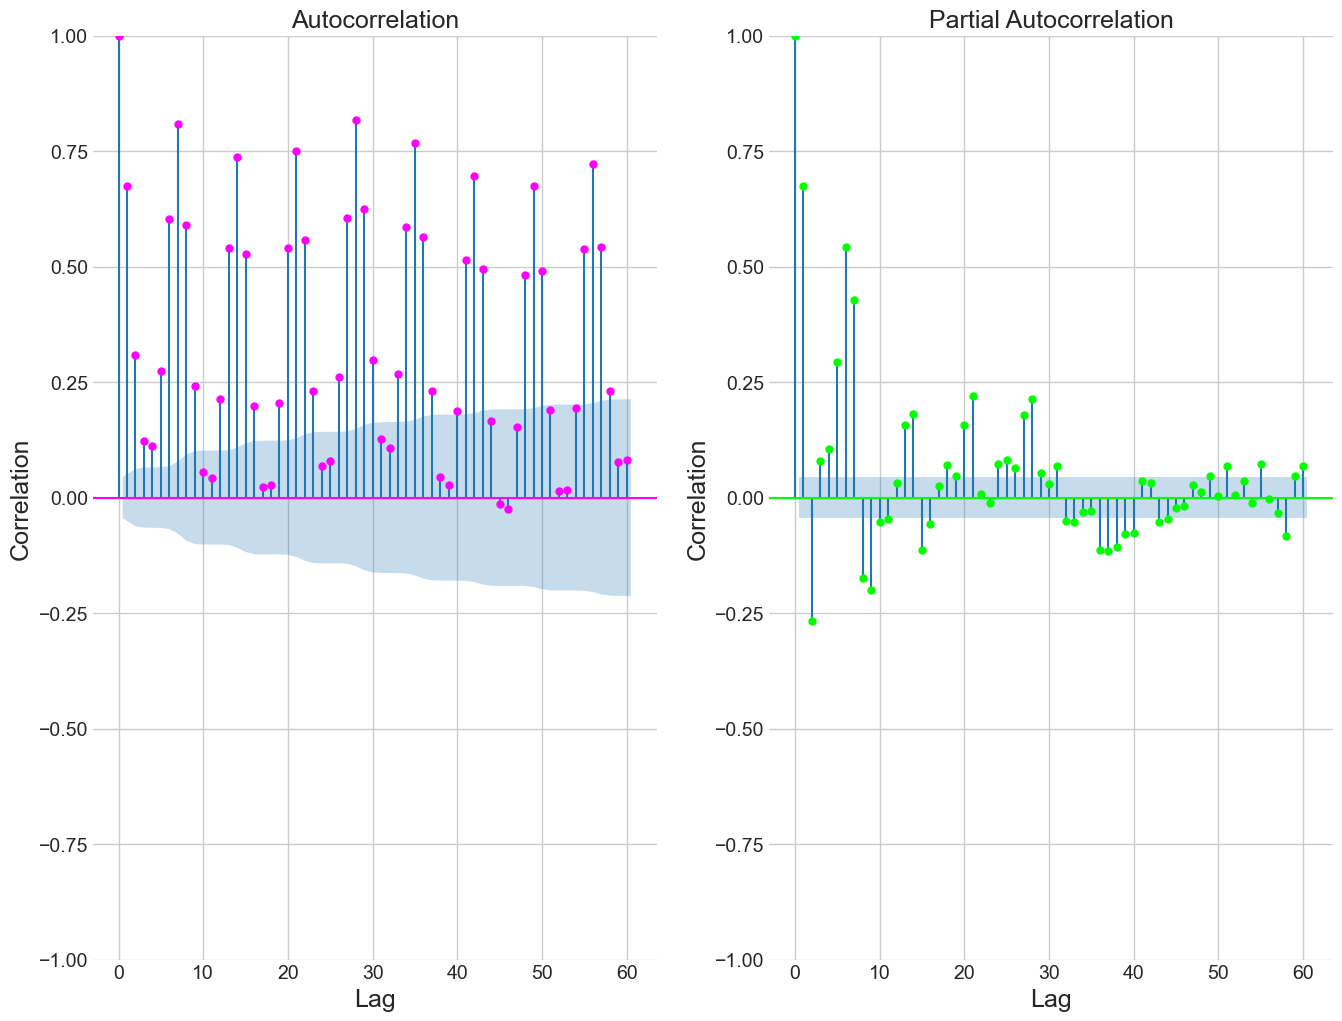

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(total_sales["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation", fontsize=18);
axs[0].set_xlabel('Lag', fontsize=18)
axs[0].set_ylabel('Correlation', fontsize=18)
axs[0].tick_params(axis='both', labelsize=14)

plot_pacf(total_sales["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation', fontsize=18)
axs[1].set_xlabel('Lag', fontsize=18)
axs[1].set_ylabel('Correlation', fontsize=18)
axs[1].tick_params(axis='both', labelsize=14)

plt.show()

## Data Splitting and evaluation functions

In [37]:
# Splitting the data into train and test data
h = 28
horizon = 28
val = 365
# Train and test data without holidays
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
#Y_df[Y_df['ds'] > '2014-01-01']
Y_test_df = Y_df.groupby('unique_id').tail(h)
#Y_validate_df = Y_df.drop(Y_test_df.index).tail(val)
Y_train_df = Y_df.drop(Y_test_df.index)

# Train and test data with holidays
df_holidays = df.loc[:, ('unique_id', 'ds', 'sales', 'snap_ca', 'Holiday_related')].rename(columns={'sales': 'y'})
df_holidays['ds'] = pd.to_datetime(df_holidays['ds'])
Y_test_exog = df_holidays.groupby('unique_id').tail(h)
#Y_validate_exog = df_holidays.drop(Y_test_exog.index).tail(val)
Y_train_exog = df_holidays.drop(Y_test_exog.index)

exog_df = df_holidays.copy().drop(columns=['y'])
exog_df['Holiday_related'].unique()
exog_df['Holiday_related'] = exog_df['Holiday_related'].astype('category').cat.codes
exog_df['snap_ca'] = exog_df['snap_ca'].astype('category').cat.codes

In [40]:
def reconcile_eval(df_hat):
        reconcilers = [
        BottomUp(),
        TopDown(method='forecast_proportions'),
        MiddleOut(middle_level='country/state_id/store_id', top_down_method='forecast_proportions'),
        MinTrace(method='ols'),
        OptimalCombination(method='wls_struct')      
        ]
        hrec = HierarchicalReconciliation(reconcilers=reconcilers)

        Y_rec = hrec.reconcile(Y_hat_df=df_hat.set_index('unique_id'), Y_df=Y_train_df.set_index('unique_id'),
                            S=S_df, tags=tags)
        
        evaluator = HierarchicalEvaluation(evaluators=[RMSE, MAPE, MASE])
        evaluation = evaluator.evaluate(
            Y_hat_df=Y_rec, Y_test_df=Y_test_df.set_index('unique_id'), Y_df=Y_train_df.set_index('unique_id'),
            tags=tags
        )
        return Y_rec.reset_index(), evaluation

In [41]:
def create_eval_df(reconile_results, criterion='MAPE'):
    levels = ['Overall', 'Country', 'State', 'Store', 'Category', 'Department']
    recon_type = ['BottomUp', 'TopDown', 'MiddleOut', 'MinTrace', 'Optimal']

    levels_dict = dict(zip(np.arange(6), levels))
    recon_dict = dict(zip(np.arange(6), recon_type))
    MAPE_df = reconile_results.filter(like=criterion, axis=0).reset_index().drop(columns='metric')
    levels= MAPE_df.level.unique().tolist()
    final_df = pd.DataFrame()
    full_df = pd.DataFrame()
    for level in levels:
        df = MAPE_df[MAPE_df['level']==level]
        for type in recon_type:
            df_new = df.filter(like=type, axis=1)
            df_new.columns = df_new.columns.str.split('/').str[0]
            final_df = pd.concat([final_df, df_new], axis=0)
    full_df = pd.concat([full_df, final_df], axis=0)

    type_df = pd.DataFrame(recon_type*6, columns=['type'])
    final_df['type'] = type_df['type'].values
    final_df.index = final_df.index.map(levels_dict)
    final_df.reset_index(inplace=True)
    final_df = final_df.rename(columns={'index': 'level'})
    final = pd.concat([final_df, type_df], axis=1)


    final_df.set_index(['level','type'], inplace=True)
    if criterion == 'MAPE':
        final_df = final_df*100
    return final_df

In [60]:
def create_preds_dict(reconile_preds):
    recon_type = ['BottomUp', 'TopDown', 'MiddleOut', 'MinTrace', 'Optimal']
    preds_dict = {}
    
    for type in recon_type:
        df_new = reconile_preds.filter(like=type, axis=1)
        df_new = pd.concat([reconile_preds.loc[:, ('unique_id', 'ds')], df_new], axis=1)
        df_new.columns = df_new.columns.str.split('/').str[0]
        preds_dict[type] = df_new

    return preds_dict    

## Benchmark start

## Stats models

In [111]:
fcst = StatsForecast(models=[SeasonalNaive(season_length=7), HistoricAverage(), RandomWalkWithDrift(), AutoARIMA(season_length=7), HoltWinters(season_length=7)], 
                     freq='D', n_jobs=-1)

# Fit the model by providing the dataframe directly to the fit method
fcst.fit(Y_train_df)

# Forecast the next 28 days, providing any required dataframe directly to the forecast method if needed
Y_hat_stats = fcst.forecast(df=Y_train_df, h=28, level=[95])
# Y_fitted_df = fcst.forecast_fitted_values()


c:\Users\49152\anaconda3\Lib\site-packages\statsforecast\core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [122]:
Y_hat_stats

unique_id          ds  SeasonalNaive  \
0                                   USA  2016-03-28        37360.0   
1                                   USA  2016-03-29        35475.0   
2                                   USA  2016-03-30        34786.0   
3                                   USA  2016-03-31        34003.0   
4                                   USA  2016-04-01        45611.0   
...                                 ...         ...            ...   
3187  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-20          120.0   
3188  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-21           98.0   
3189  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-22          198.0   
3190  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-23          186.0   
3191  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-24          196.0   

      SeasonalNaive-lo-95  SeasonalNaive-hi-95  HistoricAverage  \
0            19681.887000          55038.11300     34223.758000   
1            17796.887000          53153.11300     34223.758000   
2            17107.887000          52464.11300     34223.758000   
3            16324.888000          51681.11300     34223.758000   
4            27932.887000          63289.11300     34223.758000   
...                   ...                  ...              ...   
3187            22.419859            217.58014       110.461006   
3188             0.419858            195.58014       110.461006   
3189           100.419860            295.58014       110.461006   
3190            88.419860            283.58014       110.461006   
3191            98.419860            293.58014       110.461006   

      HistoricAverage-lo-95  HistoricAverage-hi-95          RWD    RWD-lo-95  \
0              19941.998000            48505.52000  46367.29000  34776.44500   
1              19941.998000            48505.52000  46374.57400  29978.30000   
2              19941.998000            48505.52000  46381.86300  26295.28700   
3              19941.998000            48505.52000  46389.15000  23189.02300   
4              19941.998000            48505.52000  46396.43800  20451.04100   
...                     ...                    ...          ...          ...   
3187              51.583878              169.33813    196.61147    -90.39970   
3188              51.583878              169.33813    196.63695    -96.36935   
3189              51.583878              169.33813    196.66241   -102.22480   
3190              51.583878              169.33813    196.68790   -107.97264   
3191              51.583878              169.33813    196.71338   -113.61890   

        RWD-hi-95    AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95  HoltWinters  \
0     57958.13300  38371.03500      32063.10500      44678.96000  39833.34000   
1     62770.84800  35772.96000      29165.34000      42380.58200  37179.60500   
2     66468.44000  35526.81600      28820.07600      42233.55500  37085.25400   
3     69589.27000  36072.78000      29282.71300      42862.84800  37404.14000   
4     72341.83600  39356.08200      32536.13700      46176.02700  40312.50400   
...           ...          ...              ...              ...          ...   
3187    483.62262    128.07947         86.43306        169.72589    136.18922   
3188    489.64325    128.82323         87.16985        170.47661    141.56868   
3189    495.54962    155.91414        114.25624        197.57205    166.60551   
3190    501.34845    190.17970        148.51767        231.84175    183.16113   
3191    507.04565    182.41356        140.75153        224.07559    172.43845   

      HoltWinters-lo-95  HoltWinters-hi-95  
0          33160.680000        46506.00400  
1          30183.783000        44175.43000  
2          29780.367000        44390.14500  
3          29802.562000        45005.71500  
4          32425.220000        48199.78500  
...                 ...                ...  
3187          94.230540          178.14790  
3188          99.405975          183.73140  
3189         124.239395          208.97163  


In [121]:
#Y_hat_stats.to_csv('data/models/Y_hat_stats.csv', index=False)

In [109]:
reconcile_eval(Y_hat_stats.reset_index())[1]

MSTL MSTL-lo-95  \
level                                    metric                       
Overall                                  RMSE     194.65     438.89   
                                         MAPE     0.1378     0.3063   
                                         MASE     0.6086     1.3879   
country                                  RMSE    2850.92     7297.9   
                                         MAPE     0.0553     0.1583   
                                         MASE     0.2957      0.848   
country/state_id                         RMSE    1144.04    2822.86   
                                         MAPE     0.0635     0.1854   
                                         MASE     0.3377      0.978   
country/state_id/store_id                RMSE     406.48     943.06   
                                         MAPE     0.0721     0.2001   
                                         MASE     0.3861      1.048   
country/state_id/store_id/cat_id         RMSE     174.17      370.1   
                                         MAPE     0.1065     0.2588   
                                         MASE     0.5087     1.2326   
country/state_id/store_id/cat_id/dept_id RMSE      94.52     196.18   
                                         MAPE     0.1649     0.3491   
                                         MASE     0.6993     1.5282   

                                                MSTL-hi-95 MSTL/BottomUp  \
level                                    metric                            
Overall                                  RMSE       360.24        204.69   
                                         MAPE       0.2991        0.1384   
                                         MASE       1.1506        0.6149   
country                                  RMSE      5340.04       3093.74   
                                         MAPE       0.1186        0.0584   
                                         MASE       0.5843        0.3156   
country/state_id                         RMSE      2308.16       1272.42   
                                         MAPE       0.1678        0.0705   
                                         MASE       0.8043        0.3827   
country/state_id/store_id                RMSE       759.11        438.47   
                                         MAPE       0.1729        0.0763   
                                         MASE        0.815        0.4157   
country/state_id/store_id/cat_id         RMSE        333.1        180.73   
                                         MAPE       0.2249        0.1068   
                                         MASE         0.97        0.5176   
country/state_id/store_id/cat_id/dept_id RMSE       160.26         94.52   
                                         MAPE       0.3572        0.1649   
                                         MASE       1.2989        0.6993   

                                                MSTL/TopDown_method-forecast_proportions  \
level                                    metric                                            
Overall                                  RMSE                                     194.93   
                                         MAPE                                     0.1382   
                                         MASE                                     0.6088   
country                                  RMSE                                    2850.92   
                                         MAPE                                     0.0553   
                                         MASE                                     0.2957   
country/state_id                         RMSE                                    1168.39   
                                         MAPE                                     0.0644   
                                         MASE                                     0.3433   
country/state_id/store_id                RMSE                                     411.44   
      

In [97]:
reconcile_eval(test_fcs.reset_index())[1]

HistoricAverage      RWD  \
level                                    metric                            
Overall                                  RMSE            508.34   496.88   
                                         MAPE            0.2272   0.2923   
                                         MASE            1.1741   1.2567   
country                                  RMSE          10726.17  8231.66   
                                         MAPE            0.1738   0.1899   
                                         MASE            1.0281   0.9384   
country/state_id                         RMSE           3673.24  3476.11   
                                         MAPE            0.1787    0.221   
                                         MASE            1.0447    1.067   
country/state_id/store_id                RMSE           1150.12  1140.75   
                                         MAPE            0.1963   0.2414   
                                         MASE            1.1287   1.1288   
country/state_id/store_id/cat_id         RMSE            403.55   420.07   
                                         MAPE            0.2155   0.2593   
                                         MASE            1.1463   1.1566   
country/state_id/store_id/cat_id/dept_id RMSE            179.96   199.64   
                                         MAPE            0.2395   0.3182   
                                         MASE            1.2002   1.3306   

                                                HistoricAverage/BottomUp  \
level                                    metric                            
Overall                                  RMSE                     508.34   
                                         MAPE                     0.2272   
                                         MASE                     1.1741   
country                                  RMSE                   10726.17   
                                         MAPE                     0.1738   
                                         MASE                     1.0281   
country/state_id                         RMSE                    3673.24   
                                         MAPE                     0.1787   
                                         MASE                     1.0447   
country/state_id/store_id                RMSE                    1150.12   
                                         MAPE                     0.1963   
                                         MASE                     1.1287   
country/state_id/store_id/cat_id         RMSE                     403.55   
                                         MAPE                     0.2155   
                                         MASE                     1.1463   
country/state_id/store_id/cat_id/dept_id RMSE                     179.96   
                                         MAPE                     0.2395   
                                         MASE                     1.2002   

                                                RWD/BottomUp  \
level                                    metric                
Overall                                  RMSE         496.88   
                                         MAPE         0.2923   
                                         MASE         1.2567   
country                                  RMSE        8231.66   
                                         MAPE         0.1899   
                                         MASE         0.9384   
country/state_id                         RMSE        3476.11   
                                         MAPE          0.221   
                                         MASE          1.067   
country/state_id/store_id                RMSE        1140.75   
                                         MAPE         0.2414   
                                         MASE         1.1288   
country/state_id/store_id/cat_id         RMSE         420.07   
                                         MAPE 

In [82]:
ARIMASummary(fcst.fitted_[0,1].model_)


ARIMA(2,0,2)(2,1,1)[7]                   

In [78]:
from statsforecast.arima import arima_string, ARIMASummary



In [22]:
fcst.forecast_times_

{'SeasonalNaive': 0.08805509997182526,
 'AutoARIMA': 5057.323684100018,
 'HoltWinters': 472.7424549999705}

In [26]:
#Y_hat_stats.to_csv('data/Ready/Y_hat_stats.csv', index=True)

In [84]:
#fcst.save('data/models/forecast.pkl')

Saving StatsForecast object of size 10.66MB.
StatsForecast object saved


In [3]:
#fcst1 = StatsForecast.load('data/models/forecast.pkl')

In [22]:
#fcst1.forecast(df=Y_train_df, h=28, level=[95])

In [20]:
Y_hat_stats = pd.read_csv('data/Ready/Y_hat_stats.csv')
Y_hat_stats
#Y_hat_df_stats = Y_hat_df.copy()

unique_id          ds  SeasonalNaive  \
0                                   USA  2016-03-28        37360.0   
1                                   USA  2016-03-29        35475.0   
2                                   USA  2016-03-30        34786.0   
3                                   USA  2016-03-31        34003.0   
4                                   USA  2016-04-01        45611.0   
...                                 ...         ...            ...   
3187  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-20          120.0   
3188  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-21           98.0   
3189  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-22          198.0   
3190  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-23          186.0   
3191  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-24          196.0   

      SeasonalNaive-lo-95  SeasonalNaive-hi-95    AutoARIMA  AutoARIMA-lo-95  \
0            19681.887000          55038.11300  38371.03500      32063.10500   
1            17796.887000          53153.11300  35772.96000      29165.34000   
2            17107.887000          52464.11300  35526.81600      28820.07600   
3            16324.888000          51681.11300  36072.78000      29282.71300   
4            27932.887000          63289.11300  39356.08200      32536.13700   
...                   ...                  ...          ...              ...   
3187            22.419859            217.58014    128.07947         86.43306   
3188             0.419858            195.58014    128.82323         87.16985   
3189           100.419860            295.58014    155.91414        114.25624   
3190            88.419860            283.58014    190.17970        148.51767   
3191            98.419860            293.58014    182.41356        140.75153   

      AutoARIMA-hi-95  HoltWinters  HoltWinters-lo-95  HoltWinters-hi-95  
0         44678.96000  39833.34000       33160.680000        46506.00400  
1         42380.58200  37179.60500       30183.783000        44175.43000  
2         42233.55500  37085.25400       29780.367000        44390.14500  
3         42862.84800  37404.14000       29802.562000        45005.71500  
4         46176.02700  40312.50400       32425.220000        48199.78500  
...               ...          ...                ...                ...  
3187        169.72589    136.18922          94.230540          178.14790  
3188        170.47661    141.56868          99.405975          183.73140  
3189        197.57205    166.60551         124.239395          208.97163  
3190        231.84175    183.16113         140.592210          225.73006  
3191        224.07559    172.43845         129.667310          215.20958  

[3192 rows x 11 columns]

In [24]:
Y_hat_stats_plot = Y_hat_stats.copy()
Y_hat_stats_plot['y'] = Y_test_df['y'].values

In [30]:
Y_hat_stats_plot.set_index

unique_id          ds  SeasonalNaive  \
0                                   USA  2016-03-28        37360.0   
1                                   USA  2016-03-29        35475.0   
2                                   USA  2016-03-30        34786.0   
3                                   USA  2016-03-31        34003.0   
4                                   USA  2016-04-01        45611.0   
...                                 ...         ...            ...   
3187  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-20          120.0   
3188  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-21           98.0   
3189  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-22          198.0   
3190  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-23          186.0   
3191  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-24          196.0   

      SeasonalNaive-lo-95  SeasonalNaive-hi-95    AutoARIMA  AutoARIMA-lo-95  \
0            19681.887000          55038.11300  38371.03500      32063.10500   
1            17796.887000          53153.11300  35772.96000      29165.34000   
2            17107.887000          52464.11300  35526.81600      28820.07600   
3            16324.888000          51681.11300  36072.78000      29282.71300   
4            27932.887000          63289.11300  39356.08200      32536.13700   
...                   ...                  ...          ...              ...   
3187            22.419859            217.58014    128.07947         86.43306   
3188             0.419858            195.58014    128.82323         87.16985   
3189           100.419860            295.58014    155.91414        114.25624   
3190            88.419860            283.58014    190.17970        148.51767   
3191            98.419860            293.58014    182.41356        140.75153   

      AutoARIMA-hi-95  HoltWinters  HoltWinters-lo-95  HoltWinters-hi-95  \
0         44678.96000  39833.34000       33160.680000        46506.00400   
1         42380.58200  37179.60500       30183.783000        44175.43000   
2         42233.55500  37085.25400       29780.367000        44390.14500   
3         42862.84800  37404.14000       29802.562000        45005.71500   
4         46176.02700  40312.50400       32425.220000        48199.78500   
...               ...          ...                ...                ...   
3187        169.72589    136.18922          94.230540          178.14790   
3188        170.47661    141.56868          99.405975          183.73140   
3189        197.57205    166.60551         124.239395          208.97163   
3190        231.84175    183.16113         140.592210          225.73006   
3191        224.07559    172.43845         129.667310          215.20958   

          y  
0     36041  
1     33857  
2     32359  
3     34681  
4     45536  
...     ...  
3187    148  
3188    142  
3189    166  
3190    232  
3191    201  

[3192 rows x 12 columns]

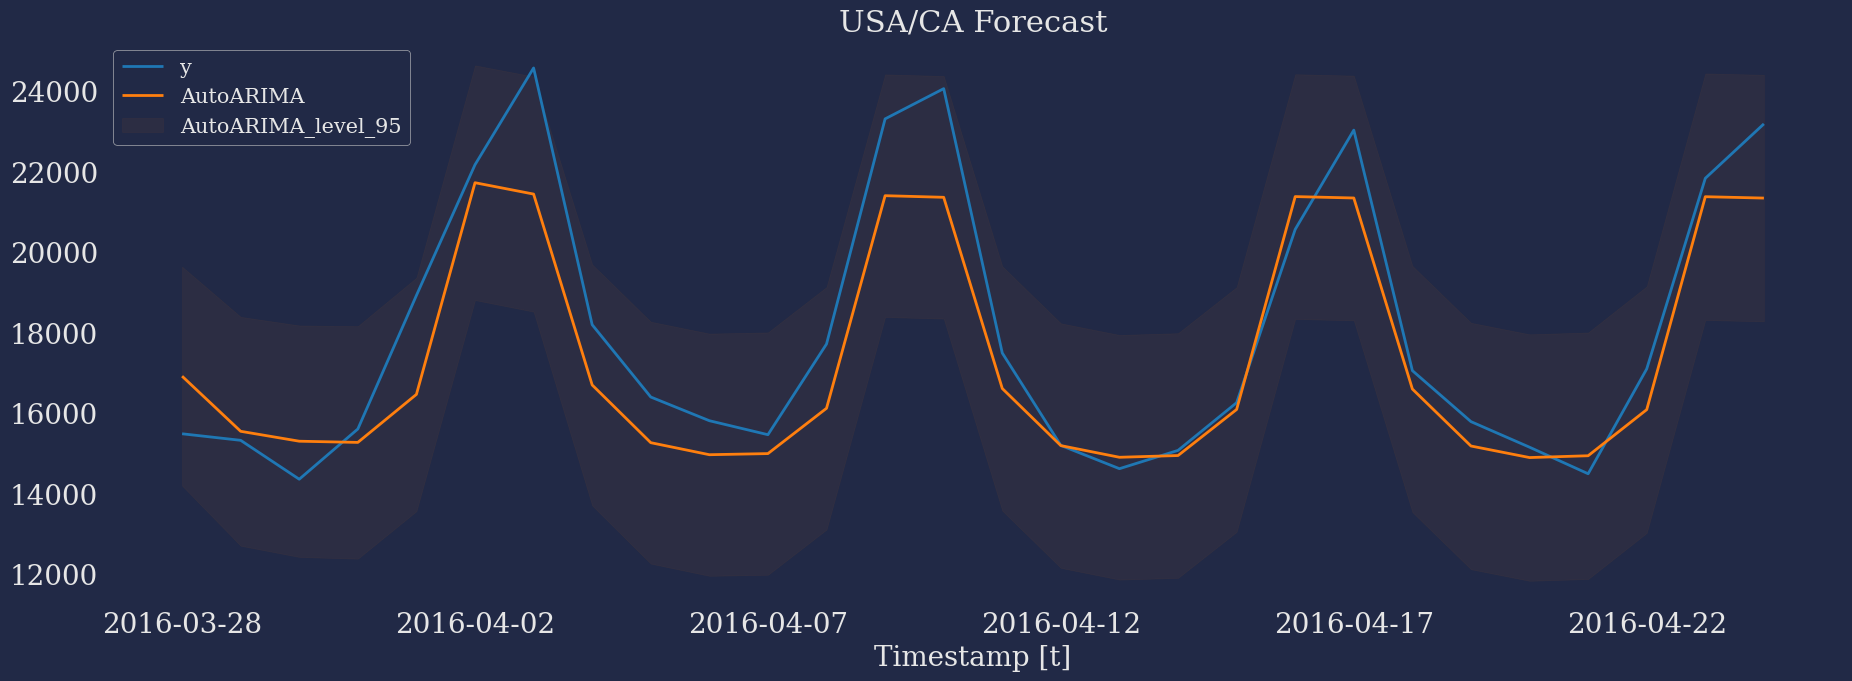

In [32]:
hplot = HierarchicalPlot(S=S_df, tags=tags)

hplot.plot_series(
    series='USA/CA',
    Y_df=Y_hat_stats_plot.set_index('unique_id'), 
    models=['y', 'AutoARIMA'],
    level=[95]
)

In [73]:
Y_hat_df1 = Y_hat_df.loc[:, ('ds', 'SeasonalNaive', 'AutoARIMA', 'HoltWinters')]

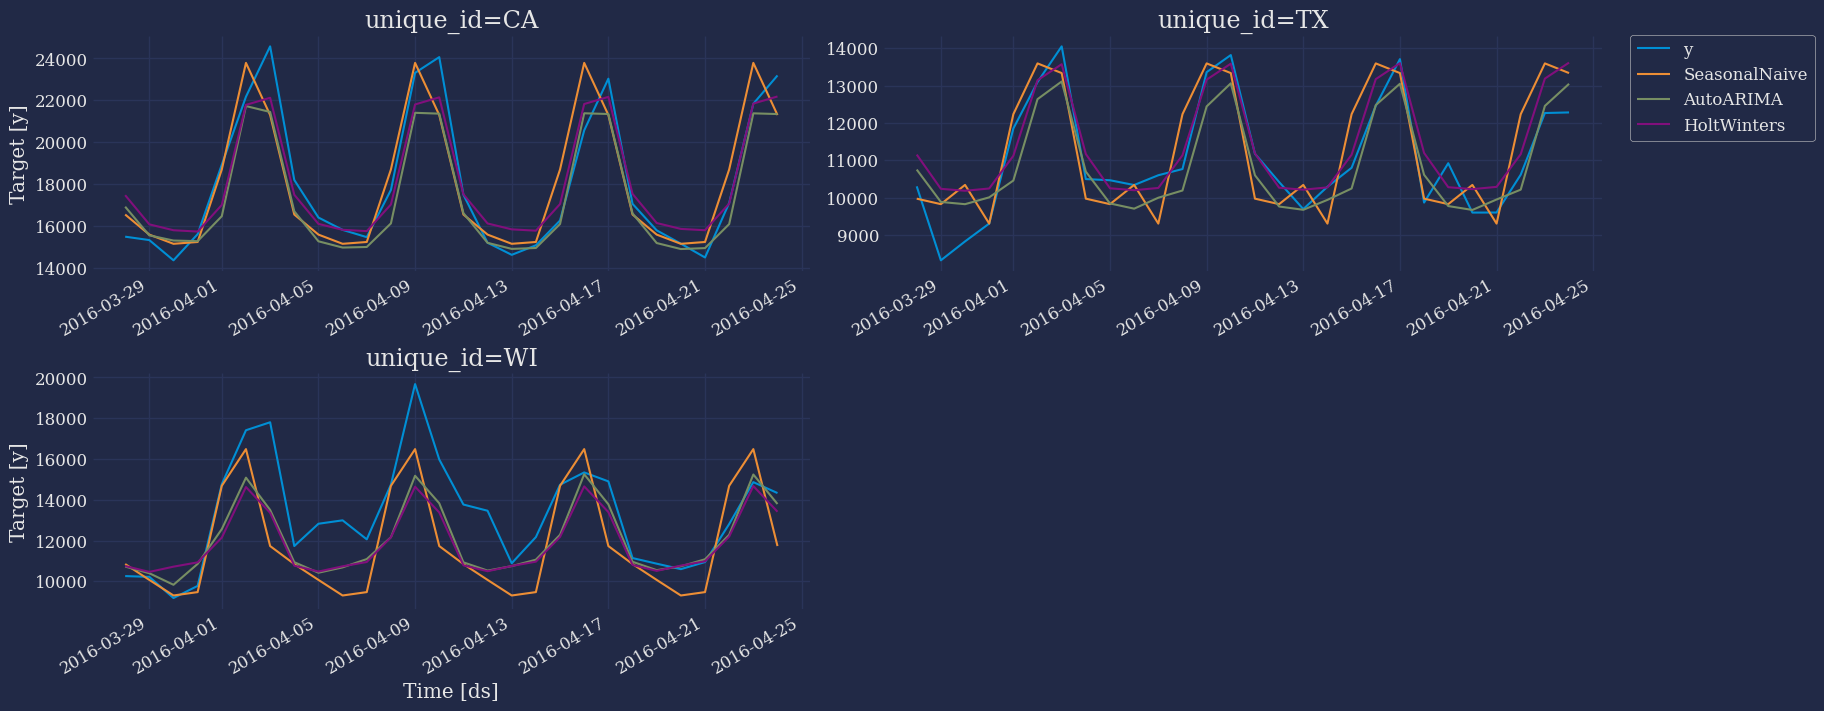

In [50]:
from utilsforecast.plotting import plot_series
fig = plot_series(Y_test_df, Y_hat_df.reset_index(), max_ids=3, plot_random=False)
fig

## ML models

#### Tuning

In [ ]:
import optuna


class StopWhenTrialKeepBeingPrunedCallback:
    def __init__(self, threshold: int):
        self.threshold = threshold
        self._consequtive_pruned_count = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.state == optuna.trial.TrialState.PRUNED:
            self._consequtive_pruned_count += 1
        else:
            self._consequtive_pruned_count = 0

        if self._consequtive_pruned_count >= self.threshold:
            study.stop()

In [49]:
def fcst_model(model):
    fcst = MLForecast(
    models=[model],
    freq='D',
    lags=[1, 7, 14, 28],

    lag_transforms={

        1: [RollingMean(window_size=7)],
        2: [RollingMean(window_size=14)],
        7: [RollingMean(window_size=28)],
        28: [RollingMean(window_size=28)],  # Long term seasonal mean
        #14: [ExpandingMean()],
        #7: [SeasonalRollingMean(window_size=28, season_length=7)],
        
    },
    date_features=["dayofweek", "month", "quarter", "year"],
    target_transforms=[Differences([7])],
)
    return fcst


def early_stopping_callback(study, trial):
    # Stop if there is no improvement over the last 10 trials
    if len(study.trials) >= 10:
        trials = study.trials[-10:]
        if all([t.value >= trial.value for t in trials]):
            study.stop()

In [ ]:
optuna_opt(RandomForestRegressor, {'n_estimators': 2, 'max_depth': 10}, 'RandomForestRegressor', 1)

In [52]:
# Define the objective function for XGBRegressor
Y_train_df["ds"] = pd.to_datetime(Y_train_df["ds"])
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    # Suggest hyperparameters for the trial
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'verbosity': 0,  # Suppress detailed output
        'random_state': 42,  # For reproducibility
        'n_jobs': -1  # Use all available cores
    }

    xgb = XGBRegressor(**param)
    fcst = MLForecast(
    models=[xgb],
    freq='D',
    lags=[1, 7, 14, 28],

    lag_transforms={

        1: [RollingMean(window_size=7)],
        2: [RollingMean(window_size=14)],
        7: [RollingMean(window_size=28)],
        28: [RollingMean(window_size=28)],  # Long term seasonal mean
        #14: [ExpandingMean()],
        #7: [SeasonalRollingMean(window_size=28, season_length=7)],
        
    },
    date_features=["dayofweek", "month", "quarter", "year"],
    target_transforms=[Differences([7])],
)


    cv_df = fcst.cross_validation(Y_train_df, n_windows=5, h=h, step_size=h, prediction_intervals=PredictionIntervals(h=h))
    evaluations = []
    # Simple train-test split
    for cutoff in cv_df['cutoff'].unique():
        # Filter forecasts for the current cutoff
        cv_df_cutoff = cv_df[cv_df['cutoff'] == cutoff].drop(columns=['cutoff'])
    
    # Train the XGBRegressor with suggested hyperparameters
    
    # Make predictions and calculate the mean squared error
    
        score = rmse(cv_df_cutoff['XGBRegressor'], cv_df_cutoff['y'])  # Use MSE for minimization
        evaluations.append(score)
        
    return np.mean(evaluations)

# Create an Optuna study with a fixed seed for reproducibility
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

# Define the number of trials
n_trials = 50  # You can adjust this based on your resources

# Use tqdm to display the progress
with tqdm(total=n_trials) as pbar:
    def tqdm_callback(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=n_trials, callbacks=[tqdm_callback])

# Output the best hyperparameters found
print("Best hyperparameters: ", study.best_params)
xgb = XGBRegressor(**study.best_params, random_state=42, n_jobs=-1)



#Y_train_df["unique_id"] = Y_train_df["unique_id"].astype("category").cat.codes


Best hyperparameters:  {'n_estimators': 697, 'learning_rate': 0.01598692070309752, 'max_depth': 8, 'gamma': 1.1071918100046745, 'subsample': 0.5114951587573802, 'colsample_bytree': 0.8667540775981647}


  0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters:  {'n_estimators': 697, 'learning_rate': 0.01598692070309752, 'max_depth': 8, 'gamma': 1.1071918100046745, 'subsample': 0.5114951587573802, 'colsample_bytree': 0.8667540775981647}


In [24]:
Best_params = {'n_estimators': 697, 'learning_rate': 0.01598692070309752, 'max_depth': 8, 'gamma': 1.1071918100046745, 'subsample': 0.5114951587573802, 'colsample_bytree': 0.8667540775981647}
xgb = XGBRegressor(**Best_params, random_state=42, n_jobs=-1)

In [366]:
# # Define the objective function for XGBRegressor
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# def objective(trial):
#     # Suggest hyperparameters for the trial
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'gamma': trial.suggest_float('gamma', 0, 5),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'verbosity': 0,  # Suppress detailed output
#         'random_state': 42,  # For reproducibility
#         'n_jobs': -1  # Use all available cores
#     }

#     # Simple train-test split
#     test_df = df.groupby('unique_id').tail(28)
#     train_df = df.drop(test_df.index)
    
#     # Train the XGBRegressor with suggested hyperparameters
#     model = XGBRegressor(**param)
#     model.fit(train_df[features], train_df['y'])
    
#     # Make predictions and calculate the mean squared error
#     preds = model.predict(test_df[features])
#     score = rmse(test_df['y'], preds)  # Use MSE for minimization
    
#     return score

# # Create an Optuna study with a fixed seed for reproducibility
# sampler = TPESampler(seed=42)
# study = optuna.create_study(direction='minimize', sampler=sampler)

# # Define the number of trials
# n_trials = 50  # You can adjust this based on your resources

# # Use tqdm to display the progress
# with tqdm(total=n_trials) as pbar:
#     def tqdm_callback(study, trial):
#         pbar.update(1)

#     study.optimize(objective, n_trials=n_trials, callbacks=[tqdm_callback])

# # Output the best hyperparameters found
# print("Best hyperparameters: ", study.best_params)
# xgb = XGBRegressor(**study.best_params, random_state=42, n_jobs=-1)

  0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters:  {'n_estimators': 340, 'learning_rate': 0.050957557274095996, 'max_depth': 10, 'gamma': 1.3488588712924825, 'subsample': 0.9247472784457411, 'colsample_bytree': 0.7955616490516791}


In [31]:
#best_params_xgb = {'n_estimators': 601, 'learning_rate': 0.014484372294290714, 'max_depth': 10, 'gamma': 3.754284299780571, 'subsample': 0.8582541251032355, 'colsample_bytree': 0.798498167073439}
best_params_xgb =   {'n_estimators': 340, 'learning_rate': 0.050957557274095996, 'max_depth': 10, 'gamma': 1.3488588712924825, 'subsample': 0.9247472784457411, 'colsample_bytree': 0.7955616490516791}

xgb = XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1)

In [73]:
# Hyptertune the LightGBM model using Optuna
def objective(trial):
    df = fcst_model(RandomForestRegressor).preprocess(Y_train_df)
    df['unique_id'] = df['unique_id'].astype('category').cat.codes
    # Suggest hyperparameters for the trial
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 8, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),  # Minimum number of samples required to split an internal node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),  # Minimum number of samples required to be at a leaf node
        }

    
    
    # Simple train-test split
    test_df = df.groupby('unique_id').tail(28)
    train_df = df.drop(test_df.index)
    
    # Train the LightGBM model with suggested hyperparameters
    model = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
    model.fit(train_df.index.values.reshape(-1, 1), train_df['y'])
    
    # Make predictions and calculate the mean squared error
    preds = model.predict(test_df.index.values.reshape(-1, 1))
    score = MAE(test_df['y'], preds)
    
    return score

# Create an Optuna study with a fixed seed for reproducibility
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

# Define the number of trials
n_trials = 50  # Set to 100 trials for the complexity and size of the dataset

# Use tqdm to display the progress
with tqdm(total=n_trials) as pbar:
    def tqdm_callback(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=n_trials, callbacks=[tqdm_callback])
rf_best_params = study.best_params  # Save the best hyperparameters

# Output the best hyperparameters found
print("Best hyperparameters: ", rf_best_params)
#lightgbm = LGBMRegressor(**study.best_params, n_jobs=-1, random_state=42)

  0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters:  {'n_estimators': 1000, 'max_depth': 8}


In [391]:
# # Hyptertune the LightGBM model using Optuna
# def objective(trial):
#     df = fcst.preprocess(Y_train_df)
#     # Suggest hyperparameters for the trial
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#         'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'verbosity': -1  # Suppress warnings from LightGBM
#     }
    
#     # Simple train-test split
#     test_df = df.groupby('unique_id').tail(28)
#     train_df = df.drop(test_df.index)
    
#     # Train the LightGBM model with suggested hyperparameters
#     model = LGBMRegressor(**param, n_jobs=-1, random_state=42)
#     model.fit(train_df.index.values.reshape(-1, 1), train_df['y'])
    
#     # Make predictions and calculate the mean squared error
#     preds = model.predict(test_df.index.values.reshape(-1, 1))
#     score = MAE(test_df['y'], preds)
    
#     return score

# # Create an Optuna study with a fixed seed for reproducibility
# sampler = TPESampler(seed=42)
# study = optuna.create_study(direction='minimize', sampler=sampler)

# # Define the number of trials
# n_trials = 50  # Set to 100 trials for the complexity and size of the dataset

# # Use tqdm to display the progress
# with tqdm(total=n_trials) as pbar:
#     def tqdm_callback(study, trial):
#         pbar.update(1)

#     study.optimize(objective, n_trials=n_trials, callbacks=[tqdm_callback])

# # Output the best hyperparameters found
# print("Best hyperparameters: ", study.best_params)
# lightgbm = LGBMRegressor(**study.best_params, n_jobs=-1, random_state=42)

  0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters:  {'n_estimators': 914, 'learning_rate': 0.04930911952585234, 'max_depth': 4, 'num_leaves': 288, 'min_child_samples': 75, 'subsample': 0.7813181690159888, 'colsample_bytree': 0.7102424998037822}


In [200]:
# best_params_lightgbm = {'n_estimators': 914, 'learning_rate': 0.04930911952585234, 'max_depth': 4, 'num_leaves': 288, 'min_child_samples': 75, 'subsample': 0.7813181690159888, 'colsample_bytree': 0.7102424998037822}
# best_params_lightgbm=  {'n_estimators': 500, 'learning_rate': 0.017987863473362915, 'max_depth': 4, 'num_leaves': 111, 'min_child_samples': 45, 'subsample': 0.6356745158869479, 'colsample_bytree': 0.9143687545759647}
# best_params_lightgbm = {'n_estimators': 800, 'learning_rate': 0.04930911952585234, 'max_depth': 6, 'num_leaves': 288, 'min_child_samples': 75,  'colsample_bytree': 0.7102424998037822}

# lightgbm = LGBMRegressor(**best_params_lightgbm, n_jobs=-1, random_state=42, verbosity=-1)

In [25]:
# 1 hour cross validated parameter search
# Best_params = {'n_estimators': 697, 'learning_rate': 0.01598692070309752, 'max_depth': 8, 'gamma': 1.1071918100046745, 'subsample': 0.5114951587573802, 'colsample_bytree': 0.8667540775981647}
# xgb = XGBRegressor(**Best_params, random_state=42, n_jobs=-1)

In [51]:
# Y_train_df["ds"] = pd.to_datetime(Y_train_df["ds"])
# #Y_train_df["unique_id"] = Y_train_df["unique_id"].astype("category").cat.codes
# fcst = MLForecast(
#     models=[],
#     freq='D',
#     lags=[1, 7,  28],  # Including more lags

#     lag_transforms={
#         1: [RollingMean(window_size=7)],
#         #2: [RollingMean(window_size=7)],
#         7: [RollingMean(window_size=7)],
#         #14: [RollingMean(window_size=14)],
#         28: [RollingMean(window_size=28)],  # Long term seasonal mean
#     },
#     date_features=["dayofweek", "month", "quarter", "year"],
#     target_transforms=[Differences([7, 28])]  # Removing weekly and monthly seasonality
# )

In [18]:
# Y_train_df["ds"] = pd.to_datetime(Y_train_df["ds"])
# #Y_train_df["unique_id"] = Y_train_df["unique_id"].astype("category").cat.codes
# fcst = MLForecast(
#     models=[xgb, lightgbm],
#     freq='D',
#     lags=[1, 7,  28],  # Including more lags

#     lag_transforms={
#         1: [RollingMean(window_size=7)],
#         #2: [RollingMean(window_size=7)],
#         7: [RollingMean(window_size=7)],
#         #14: [RollingMean(window_size=14)],
#         28: [RollingMean(window_size=28)],  # Long term seasonal mean
#     },
#     date_features=["dayofweek", "month", "quarter", "year"],
#     target_transforms=[Differences([7, 28])]  # Removing weekly and monthly seasonality
# )

# cv_df = fcst.cross_validation(Y_train_df, n_windows=5, h=h, step_size=h, prediction_intervals=PredictionIntervals(h=h), level=[95])
# #Y_hat_df_ml = fcst.predict(h, level=[95])


### No Holiday and events

In [59]:
time_dict = {}

In [126]:
best_params_lightgbm = {'n_estimators': 2500, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 500, 'min_child_samples': 75,  'colsample_bytree': 0.7102424998037822}

lightgbm = LGBMRegressor(**best_params_lightgbm,  n_jobs=-1, random_state=42, verbosity=-1)

Y_train_df["ds"] = pd.to_datetime(Y_train_df["ds"])
fcst = MLForecast(
    models=[lightgbm],
    freq='D',
    lags=np.arange(1, 29, 1).tolist(),

    lag_transforms={

        1: [RollingMean(window_size=90), RollingStd(window_size=7), SeasonalRollingMean(window_size=28, season_length=7)],
        7: [RollingMean(window_size=7), RollingStd(window_size=7), SeasonalRollingMean(window_size=28, season_length=7)],
        14: [RollingMean(window_size=14), RollingStd(window_size=7), SeasonalRollingMean(window_size=28, season_length=7)],
        28: [RollingMean(window_size=28), RollingStd(window_size=7),SeasonalRollingMean(window_size=28, season_length=7)],

        
    },
    date_features=["dayofweek", "month", "quarter", "year"],
    
)
start_time = time.time()
fcst.fit(Y_train_df)
finish_time = time.time()
time_dict['LGBMRegressor'] = int(finish_time - start_time)
Y_hat_ml = fcst.predict(h)

In [285]:
reconcile_eval(Y_hat_ml)[1]

LGBMRegressor  \
level                                    metric                 
Overall                                  RMSE          164.23   
                                         MAPE          0.1175   
                                         MASE          0.5116   
country                                  RMSE         2372.34   
                                         MAPE          0.0439   
                                         MASE          0.2356   
country/state_id                         RMSE          973.14   
                                         MAPE          0.0563   
                                         MASE          0.2812   
country/state_id/store_id                RMSE          357.82   
                                         MAPE          0.0679   
                                         MASE          0.3403   
country/state_id/store_id/cat_id         RMSE          150.74   
                                         MAPE          0.0959   
                                         MASE          0.4509   
country/state_id/store_id/cat_id/dept_id RMSE           76.14   
                                         MAPE          0.1375   
                                         MASE          0.5759   

                                                LGBMRegressor/BottomUp  \
level                                    metric                          
Overall                                  RMSE                   159.48   
                                         MAPE                   0.1166   
                                         MASE                    0.509   
country                                  RMSE                  2151.64   
                                         MAPE                   0.0428   
                                         MASE                   0.2256   
country/state_id                         RMSE                   931.92   
                                         MAPE                   0.0543   
                                         MASE                   0.2806   
country/state_id/store_id                RMSE                   343.69   
                                         MAPE                   0.0644   
                                         MASE                   0.3297   
country/state_id/store_id/cat_id         RMSE                   148.87   
                                         MAPE                   0.0938   
                                         MASE                   0.4449   
country/state_id/store_id/cat_id/dept_id RMSE                    76.14   
                                         MAPE                   0.1375   
                                         MASE                   0.5759   

                                                LGBMRegressor/TopDown_method-forecast_proportions  \
level                                    metric                                                     
Overall                                  RMSE                                              173.33   
                                         MAPE                                              0.1245   
                                         MASE                                              0.5474   
country                                  RMSE                                             2372.34   
                                         MAPE                                              0.0439   
                                         MASE                                              0.2356   
country/state_id                         RMSE                                             1046.63   
                                         MAPE                                               0.057   
                                         MASE                                              0.2898   
country/state_id/store_id                RMSE                                               384.3   
                                         MAPE         

### Holiday and events

In [63]:
# Train and test data with holidays
df_holidays = df.loc[:, ('unique_id', 'ds', 'sales', 'snap_ca', 'Holiday_related')].rename(columns={'sales': 'y'})
df_holidays['ds'] = pd.to_datetime(df_holidays['ds'])
Y_test_exog = df_holidays.groupby('unique_id').tail(h)
#Y_validate_exog = df_holidays.drop(Y_test_exog.index).tail(val)
Y_train_exog = df_holidays.drop(Y_test_exog.index)

exog_df = df_holidays.copy().drop(columns=['y'])
exog_df['Holiday_related'].unique()
exog_df['Holiday_related'] = exog_df['Holiday_related'].astype('category').cat.codes
exog_df['snap_ca'] = exog_df['snap_ca'].astype('category').cat.codes

In [45]:
# exog_df['dayofweek'] = exog_df['ds'].dt.dayofweek
# exog_df['month'] = exog_df['ds'].dt.month
# exog_df['quarter'] = exog_df['ds'].dt.quarter
# exog_df['year'] = exog_df['ds'].dt.year
# Y_train_exog['dayofweek'] = Y_train_exog['ds'].dt.dayofweek
# Y_train_exog['month'] = Y_train_exog['ds'].dt.month
# Y_train_exog['quarter'] = Y_train_exog['ds'].dt.quarter
# Y_train_exog['year'] = Y_train_exog['ds'].dt.year

In [134]:
best_params_lightgbm = {'n_estimators': 2000, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 500, 'min_child_samples': 75,  'colsample_bytree': 0.7102424998037822}

lightgbm = LGBMRegressor(**best_params_lightgbm,  n_jobs=-1, random_state=42, verbosity=-1)

Y_train_df["ds"] = pd.to_datetime(Y_train_df["ds"])
fcst = MLForecast(
    models=[lightgbm],
    freq='D',
    lags=np.arange(1, 29, 1).tolist(),

    lag_transforms={

        1: [RollingMean(window_size=90), RollingStd(window_size=7), SeasonalRollingMean(window_size=28, season_length=7)],
        7: [RollingMean(window_size=7), RollingStd(window_size=7), SeasonalRollingMean(window_size=28, season_length=7)],
        14: [RollingMean(window_size=14), RollingStd(window_size=7), SeasonalRollingMean(window_size=28, season_length=7)],
        28: [RollingMean(window_size=28), RollingStd(window_size=7), SeasonalRollingMean(window_size=28, season_length=7)],

          },
    date_features=["dayofweek", "month", "quarter", "year"],
    
)


start_time = time.time()
fcst.fit(Y_train_exog, static_features=[])
finish_time = time.time()
#training_time_dict['LightBGM_cov'] = finish_time - start_time
Y_hat_ml_covs = fcst.predict(h, X_df=exog_df)  

In [135]:
reconcile_eval(Y_hat_ml_covs)[1]

LGBMRegressor  \
level                                    metric                 
Overall                                  RMSE          157.01   
                                         MAPE          0.1144   
                                         MASE          0.5244   
country                                  RMSE         2148.09   
                                         MAPE          0.0373   
                                         MASE          0.2071   
country/state_id                         RMSE          923.31   
                                         MAPE          0.0502   
                                         MASE           0.259   
country/state_id/store_id                RMSE          322.25   
                                         MAPE           0.057   
                                         MASE          0.3046   
country/state_id/store_id/cat_id         RMSE          145.09   
                                         MAPE          0.0928   
                                         MASE          0.4569   
country/state_id/store_id/cat_id/dept_id RMSE           77.23   
                                         MAPE          0.1356   
                                         MASE          0.6007   

                                                LGBMRegressor/BottomUp  \
level                                    metric                          
Overall                                  RMSE                   169.96   
                                         MAPE                   0.1163   
                                         MASE                   0.5385   
country                                  RMSE                   2565.3   
                                         MAPE                    0.049   
                                         MASE                    0.267   
country/state_id                         RMSE                  1037.59   
                                         MAPE                   0.0565   
                                         MASE                    0.307   
country/state_id/store_id                RMSE                   368.87   
                                         MAPE                   0.0653   
                                         MASE                   0.3603   
country/state_id/store_id/cat_id         RMSE                   153.42   
                                         MAPE                   0.0965   
                                         MASE                    0.485   
country/state_id/store_id/cat_id/dept_id RMSE                    77.23   
                                         MAPE                   0.1356   
                                         MASE                   0.6007   

                                                LGBMRegressor/TopDown_method-forecast_proportions  \
level                                    metric                                                     
Overall                                  RMSE                                              162.99   
                                         MAPE                                              0.1171   
                                         MASE                                              0.5301   
country                                  RMSE                                             2148.09   
                                         MAPE                                              0.0373   
                                         MASE                                              0.2071   
country/state_id                         RMSE                                              986.78   
                                         MAPE                                              0.0546   
                                         MASE                                              0.2872   
country/state_id/store_id                RMSE                                              358.32   
                                         MAPE         

## Neural Networks 

### Tuning

In [171]:
# def objective(trial, data, horizon):
#     # Hyperparameters to tune
#     encoder_hidden_size = trial.suggest_int('encoder_hidden_size', 32, 128)
#     decoder_hidden_size = trial.suggest_int('decoder_hidden_size', 32, 128)
#     batch_size = trial.suggest_categorical('batch_size', [64, 86, 128])
#     max_steps = trial.suggest_int('max_steps', 300, 700)

#     # Model setup
#     models = [
#         LSTM(h=horizon, max_steps=max_steps, batch_size=batch_size, 
#              scaler_type='standard', encoder_hidden_size=encoder_hidden_size, 
#              decoder_hidden_size=decoder_hidden_size),
#         NBEATS(input_size=2 * horizon, h=horizon, batch_size=batch_size, max_steps=max_steps),
#         NHITS(input_size=2 * horizon, h=horizon, batch_size=batch_size, max_steps=max_steps)
#     ]

#     # Initialize and fit the NeuralForecast model
#     nf = NeuralForecast(models=models, freq='D')
#     nf.fit(data)
#     assign_folds(Y_train_df, n_folds=5, fold_size=28)
#     # Assume there's a method to calculate validation error, here we just return a dummy value
#     # In practice, you should replace this with actual model evaluation logic
#     validation_error = nf.validate(data)  # This is a placeholder
    
#     return validation_error

# def main(Y_train_df):
#     study = optuna.create_study(direction='minimize')
#     study.optimize(lambda trial: objective(trial, Y_train_df, horizon=28), n_trials=100)

#     print("Best hyperparameters: {}".format(study.best_params))

# # Example usage, assuming Y_train_df is your training DataFrame
# main(Y_train_df)


In [26]:
# from ray.tune.search.hyperopt import HyperOptSearch
# import hyperopt 
# from ray import tune


In [64]:
lstm_default_config = AutoLSTM.get_default_config(h = 28, backend="optuna")                   # Extract the default hyperparameter settings
def config_nhits(trial):
    config = {**lstm_default_config(trial)}
    return config

In [40]:
Y_train_df['ds'] = pd.to_datetime(Y_train_df['ds'])

In [79]:
best_params_nhits = nf_nhits.models[0].results.best_params
best_params_nhits

{'max_steps': 750,
 'input_size': 52,
 'learning_rate': 0.002881039938003378,
 'random_seed': 3}

In [57]:
best_params_lstm = nf.models[0].results.best_params
best_params_lstm

{'max_steps': 1000,
 'input_size': 40,
 'encoder_n_layers': 2,
 'encoder_hidden_size': 128,
 'decoder_hidden_size': 96,
 'learning_rate': 0.001278501682806079,
 'random_seed': 3}

In [48]:
Informer_default_config = AutoInformer.get_default_config(h = 28, backend="optuna")                 # Extract the default hyperparameter settings
def config_informer(trial):
    config = {**Informer_default_config(trial)}
    return config

In [135]:
lstm_params =  {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.0005532382940613809, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 13, 'input_size': -28, 'inference_input_size': -28}

In [175]:
from neuralforecast.losses.pytorch import MAPE as mape_torch

In [ ]:
from utilsforecast.plotting import plot_series
fig = plot_series(Y_test_df, Y_hat_all, max_ids=3, plot_random=False)
fig

In [182]:
horizon = 28
models = [AutoNHITS(h=horizon, backend="optuna", config=None)]
          

nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_df)
Y_hat_df_neural = nf.predict().reset_index()
reconcile_eval(Y_hat_df_neural)[1]

[I 2024-09-30 23:12:33,599] A new study created in memory with name: no-name-fe217e19-c4eb-4833-89f7-5fc0f8e5be43
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: User

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1200.0` reached.
[I 2024-09-30 23:13:22,127] Trial 0 finished with value: 284.7347412109375 and parameters: {'n_pool_kernel_size': [2, 2, 1], 'n_freq_downsample': [168, 24, 1], 'learning_rate': 0.0003427464014068459, 'scaler_type': 'robust', 'max_steps': 1200.0, 'batch_size': 128, 'windows_batch_size': 256, 'random_seed': 11, 'input_size': 28, 'step_size': 28}. Best is trial 0 with value: 284.7347412109375.
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1100.0` reached.
[I 2024-09-30 23:14:04,730] Trial 1 finished with value: 308.0693664550781 and parameters: {'n_pool_kernel_size': [16, 8, 1], 'n_freq_downsample': [168, 24, 1], 'learning_rate': 0.002883627763283509, 'scaler_type': None, 'max_steps': 1100.0, 'batch_size': 256, 'windows_batch_size': 1024, 'random_seed': 16, 'input_size': 28, 'step_size': 28}. Best is trial 0 with value: 284.7347412109375.
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\ana

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=700.0` reached.
[I 2024-09-30 23:14:31,131] Trial 2 finished with value: 279.9044189453125 and parameters: {'n_pool_kernel_size': [4, 4, 4], 'n_freq_downsample': [60, 8, 1], 'learning_rate': 0.00021410940742803608, 'scaler_type': None, 'max_steps': 700.0, 'batch_size': 128, 'windows_batch_size': 1024, 'random_seed': 6, 'input_size': 84, 'step_size': 28}. Best is trial 2 with value: 279.9044189453125.
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anacond

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=900.0` reached.
[I 2024-09-30 23:15:12,856] Trial 3 finished with value: 136.1604461669922 and parameters: {'n_pool_kernel_size': [8, 4, 1], 'n_freq_downsample': [180, 60, 1], 'learning_rate': 0.0008095835600189156, 'scaler_type': 'robust', 'max_steps': 900.0, 'batch_size': 128, 'windows_batch_size': 256, 'random_seed': 18, 'input_size': 56, 'step_size': 1}. Best is trial 3 with value: 136.1604461669922.
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\ana

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1200.0` reached.
[I 2024-09-30 23:15:50,572] Trial 4 finished with value: 142.82533264160156 and parameters: {'n_pool_kernel_size': [1, 1, 1], 'n_freq_downsample': [180, 60, 1], 'learning_rate': 0.001215265736196132, 'scaler_type': None, 'max_steps': 1200.0, 'batch_size': 64, 'windows_batch_size': 512, 'random_seed': 7, 'input_size': 56, 'step_size': 1}. Best is trial 3 with value: 136.1604461669922.
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anacond

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=800.0` reached.
[I 2024-09-30 23:16:13,283] Trial 5 finished with value: 182.4046630859375 and parameters: {'n_pool_kernel_size': [4, 4, 4], 'n_freq_downsample': [40, 20, 1], 'learning_rate': 0.01745074855955037, 'scaler_type': 'robust', 'max_steps': 800.0, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 8, 'input_size': 84, 'step_size': 1}. Best is trial 3 with value: 136.1604461669922.
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1300.0` reached.
[I 2024-09-30 23:16:46,295] Trial 6 finished with value: 6029682688.0 and parameters: {'n_pool_kernel_size': [16, 8, 1], 'n_freq_downsample': [1, 1, 1], 'learning_rate': 0.09080993110063708, 'scaler_type': None, 'max_steps': 1300.0, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 17, 'input_size': 56, 'step_size': 1}. Best is trial 3 with value: 136.1604461669922.
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\s

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500.0` reached.
[I 2024-09-30 23:17:01,509] Trial 7 finished with value: 305.3411865234375 and parameters: {'n_pool_kernel_size': [4, 4, 4], 'n_freq_downsample': [168, 24, 1], 'learning_rate': 0.0031332998985130977, 'scaler_type': 'robust', 'max_steps': 500.0, 'batch_size': 64, 'windows_batch_size': 1024, 'random_seed': 12, 'input_size': 56, 'step_size': 28}. Best is trial 3 with value: 136.1604461669922.
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\an

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1100.0` reached.
[I 2024-09-30 23:17:28,898] Trial 8 finished with value: 705535104.0 and parameters: {'n_pool_kernel_size': [1, 1, 1], 'n_freq_downsample': [180, 60, 1], 'learning_rate': 0.06346168743459452, 'scaler_type': None, 'max_steps': 1100.0, 'batch_size': 32, 'windows_batch_size': 128, 'random_seed': 13, 'input_size': 140, 'step_size': 28}. Best is trial 3 with value: 136.1604461669922.
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1] which is of type list.
  warnings.warn(message)
c:\Users\49152\anaconda3\Li

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1500.0` reached.
[I 2024-09-30 23:18:20,491] Trial 9 finished with value: 141.71890258789062 and parameters: {'n_pool_kernel_size': [4, 4, 4], 'n_freq_downsample': [180, 60, 1], 'learning_rate': 0.004315880719449045, 'scaler_type': 'robust', 'max_steps': 1500.0, 'batch_size': 64, 'windows_batch_size': 512, 'random_seed': 20, 'input_size': 140, 'step_size': 1}. Best is trial 3 with value: 136.1604461669922.
Seed set to 18
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=900.0` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


AutoNHITS AutoNHITS/BottomUp  \
level                                    metric                                
Overall                                  RMSE       161.4             158.72   
                                         MAPE      0.1175             0.1174   
                                         MASE      0.5099             0.5101   
country                                  RMSE     2529.34            2207.56   
                                         MAPE      0.0443             0.0391   
                                         MASE      0.2448             0.2135   
country/state_id                         RMSE      995.37             966.02   
                                         MAPE       0.054             0.0526   
                                         MASE       0.288             0.2796   
country/state_id/store_id                RMSE      335.93             342.37   
                                         MAPE      0.0608             0.0606   
                                         MASE       0.315             0.3174   
country/state_id/store_id/cat_id         RMSE      143.34             144.69   
                                         MAPE      0.0918              0.092   
                                         MASE      0.4411             0.4429   
country/state_id/store_id/cat_id/dept_id RMSE       74.63              74.63   
                                         MAPE      0.1404             0.1404   
                                         MASE      0.5805             0.5805   

                                                AutoNHITS/TopDown_method-forecast_proportions  \
level                                    metric                                                 
Overall                                  RMSE                                           168.7   
                                         MAPE                                           0.119   
                                         MASE                                          0.5234   
country                                  RMSE                                         2529.34   
                                         MAPE                                          0.0443   
                                         MASE                                          0.2448   
country/state_id                         RMSE                                         1057.01   
                                         MAPE                                          0.0561   
                                         MASE                                           0.302   
country/state_id/store_id                RMSE                                          364.27   
                                         MAPE                                          0.0643   
                                         MASE                                          0.3399   
country/state_id/store_id/cat_id         RMSE                                          150.08   
                                         MAPE                                          0.0948   
                                         MASE                                          0.4608   
country/state_id/store_id/cat_id/dept_id RMSE                                           76.95   
                                         MAPE                                           0.141   
                                         MASE                                          0.5899   

                                                AutoNHITS/MiddleOut_middle_level-country/state_id/store_id_top_down_method-forecast_proportions  \
level                                    metric                                                                                                   
Overall                                  RMSE                                               155.99                                                
                                         MAPE                    

In [185]:
nf.models[0].results.best_params 
# {'n_pool_kernel_size': [8, 4, 1],
#  'n_freq_downsample': [180, 60, 1],
#  'learning_rate': 0.0008095835600189156,
#  'scaler_type': 'robust',
#  'max_steps': 900.0,
#  'batch_size': 128,
#  'windows_batch_size': 256,
#  'random_seed': 18,
#  'input_size': 56,
#  'step_size': 1}

{'n_pool_kernel_size': [8, 4, 1],
 'n_freq_downsample': [180, 60, 1],
 'learning_rate': 0.0008095835600189156,
 'scaler_type': 'robust',
 'max_steps': 900.0,
 'batch_size': 128,
 'windows_batch_size': 256,
 'random_seed': 18,
 'input_size': 56,
 'step_size': 1}

In [221]:
nhits_params = {'n_pool_kernel_size': [8, 4, 1],
 'n_freq_downsample': [180, 60, 1],
 'learning_rate': 0.0008095835600189156,
 'scaler_type': 'robust',
 'max_steps': 900.0,
 'batch_size': 128,
 'windows_batch_size': 256,
 'random_seed': 18,
 'input_size': 56,
 'step_size': 1}

# with open('data/results/M5/nhits_params.pkl', 'wb') as f:
#     pickle.dump(nhits_params, f)

In [25]:
from neuralforecast.losses.pytorch import MAE as MAE_torch


In [26]:
TimesNet_default_config = AutoTimesNet.get_default_config(h = 28, backend="optuna")                 # Extract the default hyperparameter settings
TimesNet_default_config

<function neuralforecast.common._base_auto.BaseAuto._ray_config_to_optuna.<locals>.optuna_config(trial)>

In [27]:
def config_timesnet(trial):
    return {
        "max_steps": trial.suggest_int("max_steps", 200, 1000, step=100),                                                                                               # Number of SGD steps
        "input_size":trial.suggest_int("input_size", 28, 6*28, step=28),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),           
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),   
    }

In [28]:

horizon = 28

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # Use this to disable training prints from optuna


def config_TimesNet(trial):
    config = {**TimesNet_default_config(trial)}
    return config
models = [AutoTimesNet(h=horizon,loss=MAE_torch(), config=config_timesnet, num_samples=50, backend='optuna')]


# Informer_default_config = AutoInformer.get_default_config(h = horizon, backend="ray")
# models = AutoNHITS(h=horizon,
#                   loss=MAE_torch(),
#                   config=Informer_default_config,
#                   search_alg=HyperOptSearch(),
#                   backend='ray',
#                   num_samples=1)

nf_TimesNet = NeuralForecast(models=models, freq='D')
nf_TimesNet.fit(df=Y_train_df,  val_size=28*2)
best_params_TimesNet= nf_TimesNet.models[0].results.best_params
#best_params_informer
with open('data/models/best_params_TimesNet.pkl', 'wb') as f:
     pickle.dump(best_params_TimesNet, f)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 15.8 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.814    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=800` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 15.8 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.814    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=600` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 33.1 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.883    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 4.8 K  | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.770    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=900` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 4.8 K  | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.770    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 15.8 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.814    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 4.8 K  | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.770    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 23.7 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.846    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=900` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 9.5 K  | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.789    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 33.1 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.883    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 23.7 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.846    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 23.7 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.846    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=600` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 23.7 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.846    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=700` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 9.5 K  | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.789    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 15.8 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.814    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=800` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 1.6 K  | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.757    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 23.7 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.846    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 33.1 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.883    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=700` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 9.5 K  | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.789    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 15.8 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.814    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=800` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 23.7 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.846    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=900` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 23.7 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.846    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=900` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 23.7 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.846    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=900` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 15.8 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.814    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=700` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 33.1 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.883    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 23.7 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.846    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 15.8 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.814    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 33.1 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.883    Total estim

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
[W 2024-10-10 23:02:11,540] Trial 27 failed with parameters: {'max_steps': 400, 'input_size': 168, 'batch_size': 64, 'learning_rate': 0.012195015888401448} because of the following error: KeyError('ptl/val_loss').
Traceback (most recent call last):
  File "c:\Users\49152\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\common\_base_auto.py", line 338, in objective
    "loss": metrics["ptl/val_loss"],
            ~~~~~~~^^^^^^^^^^^^^^^^
KeyError: 'ptl/val_loss'
[W 2024-10-10 23:02:11,542] Trial 27 failed with value None.


KeyError: 'ptl/val_loss'

In [ ]:
Y_hat_preds = nf.predict().reset_index()
reconcile_eval(Y_hat_preds)[1]

In [ ]:
horizon = 28
models = [AutoPatchTST(h=horizon, backend="optuna", config=None)]
          

nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_df)
Y_hat_df_neural = nf.predict().reset_index()


### No Holidays

In [27]:
best_params_informer= {'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.005075662192578469, 'scaler_type': 'standard', 'max_steps': 2000, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 5, 'input_size': 140, 'step_size': 1}
PatchTST_params = {'hidden_size': 256, 'n_heads': 16, 'patch_len': 16, 'learning_rate': 0.0005973842209960362, 'revin': True, 'max_steps': 1000, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 17, 'input_size': 84, 'step_size': 1}
lstm_params =  {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 512, 'learning_rate': 0.0005532382940613809, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 42, 'input_size': 28*6, 'inference_input_size': -28}
#PatchTST_params = pd.read_pickle('data/results/M5/PatchTST_params.pkl')


In [66]:
models_dict = {}
# models_dict['LSTM'] = [LSTM(h=horizon, encoder_hidden_size=300, encoder_n_layers=2, context_size=5, decoder_hidden_size=512, learning_rate=0.0005532382940613809, max_steps=1000, batch_size=32, random_seed=42, input_size=28*6)]
# models_dict['TimesNet'] = [TimesNet(h=horizon, hidden_size =16,  conv_hidden_size=7, random_seed=42, max_steps=400, batch_size=64, learning_rate=0.001, input_size=6 * horizon, step_size=1)]
models_dict['NBEATS'] = [NBEATS(input_size=6 * horizon, h=horizon, stack_types = ['identity', 'trend', 'seasonality'],  batch_size=64,  random_seed=42,  max_steps=500)]
# models_dict['PatchTST'] = [PatchTST(h=horizon, hidden_size=256, n_heads=16, patch_len=16, learning_rate=0.0005973842209960362, revin=True, max_steps=1000, batch_size=32,
#                                      windows_batch_size=1024, random_seed=17, input_size=84, step_size=1)]

#models_dict['TFT'] = [TFT(h=horizon, input_size=4 * horizon,  random_seed=42, max_steps=1000, batch_size=128, learning_rate=0.001, n_head = 4, futr_exog_list = ['snap_ca',	'Holiday_related'], hist_exog_list=['snap_ca',	'Holiday_related'], scaler_type='standard')]

Seed set to 42


In [144]:
#Y_hat_tft.to_csv('data/results/M5/Y_hat_tft.csv', index=False)

In [67]:
horizon = 28
Y_hat_nn = Y_test_df.drop(columns='y').copy()
time_dict = {}
for key, value in models_dict.items():
    start_time = time.time()
    nf = NeuralForecast(models=value, freq='D', local_scaler_type='minmax')
    nf.fit(df=Y_train_df)
    Y_hat_preds = nf.predict().reset_index()
    Y_hat_nn[key] = Y_hat_preds[key].values
    finish_time = time.time()
    time_dict[key] = int(finish_time - start_time)
Y_hat_nn.reset_index(drop=True, inplace=True)
Y_hat_nn['unique_id'] = Y_hat_preds['unique_id']    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.8 M  | train
-------------------------------------------------------
2.8 M     Trainable params
11.2 K    Non-trainable params
2.8 M     Total params
11.175    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [281]:
horizon = 28
Y_hat_nn = Y_test_df.drop(columns='y').copy()
#time_dict = {}
for key, value in models_dict.items():
    start_time = time.time()
    nf = NeuralForecast(models=value, freq='D', local_scaler_type='minmax')
    nf.fit(df=Y_train_df)
    Y_hat_preds = nf.predict().reset_index()
    Y_hat_nn[key] = Y_hat_preds[key].values
    finish_time = time.time()
    time_dict[key] = int(finish_time - start_time)
Y_hat_nn.reset_index(drop=True, inplace=True)
Y_hat_nn['unique_id'] = Y_hat_preds['unique_id']    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.1 M  | train
4 | context_adapter | Linear        | 42.1 K | train
5 | mlp_decoder     | MLP           | 3.6 K  | train
----------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.527     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.8 M  | train
-------------------------------------------------------
2.8 M     Trainable params
11.2 K    Non-trainable params
2.8 M     Total params
11.175    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=600` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.998    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 1.3 M  | train
-----------------------------------------------------------
1.3 M     Trainable params
3         Non-trainable params
1.3 M     Total params
5.064     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type                 | Params | Mode 
--------------------------------------------------------------------
0  | loss              | MAE                  | 0      | train
1  | padder            | ConstantPad1d        | 0      | train
2  | scaler            | TemporalNorm         | 0      | train
3  | pdm_blocks        | ModuleList           | 273 K  | train
4  | preprocess        | SeriesDecomp         | 0      | train
5  | enc_embedding     | DataEmbedding_wo_pos | 2.5 K  | train
6  | normalize_layers  | ModuleList           | 4 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 128 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 33.1 K | train
7 | projection     | Linear        | 17     | train
----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 199 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
341 K     Trainable params
0         N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=2000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
# Y_hat_tft = pd.read_csv('data/results/M5/Y_hat_tft.csv')
# Y_hat_ml = pd.read_csv('data/results/M5/Y_hat_ml_covs.csv')
# Y_hat_nn['TFT'] = Y_hat_tft['TFT']

In [89]:
time_dict

{'LSTM': 76, 'TimesNet': 73, 'NBEATS': 18, 'PatchTST': 46, 'TFT': 239}

In [58]:
# Y_hat_nn.to_csv('data/results/M5/Y_hat_nn.csv', index=False)
# with open('data/results/M5/time_dict.pkl', 'wb') as f:
#     pickle.dump(time_dict, f)
Y_hat_ml = pd.read_csv('data/results/M5/Y_hat_ml_covs.csv')
Y_hat_nn = pd.read_csv('data/results/M5/Y_hat_nn.csv')
time_dict = pd.read_pickle('data/results/M5/time_dict.pkl')

In [69]:
reconile_results

LGBMRegressor     LSTM  \
level                                    metric                          
Overall                                  RMSE          157.01   186.21   
                                         MAPE          0.1144   0.1263   
                                         MASE          0.5244   0.5719   
country                                  RMSE         2148.09  2831.71   
                                         MAPE          0.0373   0.0524   
                                         MASE          0.2071   0.2871   
country/state_id                         RMSE          923.31  1186.65   
                                         MAPE          0.0502    0.064   
                                         MASE           0.259   0.3504   
country/state_id/store_id                RMSE          322.25   397.17   
                                         MAPE           0.057   0.0704   
                                         MASE          0.3046   0.3725   
country/state_id/store_id/cat_id         RMSE          145.09   166.09   
                                         MAPE          0.0928   0.1027   
                                         MASE          0.4569   0.5047   
country/state_id/store_id/cat_id/dept_id RMSE           77.23    84.03   
                                         MAPE          0.1356   0.1481   
                                         MASE          0.6007   0.6427   

                                                  NBEATS    NHITS PatchTST  \
level                                    metric                              
Overall                                  RMSE     145.17   147.12   153.09   
                                         MAPE     0.1118   0.1146   0.1168   
                                         MASE     0.4825   0.4828   0.5066   
country                                  RMSE    1906.99  1964.79  2249.44   
                                         MAPE     0.0341   0.0343   0.0402   
                                         MASE     0.1851   0.1837   0.2201   
country/state_id                         RMSE     859.52   893.25   946.91   
                                         MAPE     0.0486   0.0534   0.0506   
                                         MASE     0.2523   0.2731   0.2659   
country/state_id/store_id                RMSE     311.87   321.97   318.26   
                                         MAPE     0.0591   0.0626   0.0581   
                                         MASE     0.3031   0.3154   0.2983   
country/state_id/store_id/cat_id         RMSE     133.24    134.9   136.78   
                                         MAPE     0.0863   0.0884   0.0902   
                                         MASE     0.4101   0.4127   0.4313   
country/state_id/store_id/cat_id/dept_id RMSE      70.68    69.44    72.52   
                                         MAPE      0.134   0.1371   0.1406   
                                         MASE     0.5533   0.5501   0.5831   

                                                TimeMixer TimesNet Informer  \
level                                    metric                               
Overall                                  RMSE      146.59    143.0   148.42   
                                         MAPE      0.1156   0.1127   0.1127   
                                         MASE      0.4865    0.481   0.4861   
country                                  RMSE     2003.86  1908.52  1969.49   
                                         MAPE      0.0371   0.0344   0.0369   
                                         MASE      0.1963   0.1857   0.1991   
country/state_id                         RMSE      861.89   819.08   832.84   
                                         MAPE      0.0519   0.0453   0.0484   
                                         MASE      0.2657   0.2395   0.2516   
country/state_id/store_id                RMSE      318.35    303.5   322.56   
                                         MAPE      0.0602 

In [61]:
Y_hat_all = pd.concat([Y_hat_ml.iloc[:, :3], Y_hat_nn.drop(columns=['ds', 'unique_id'])], axis=1)
reconile_preds, reconile_results  = reconcile_eval(Y_hat_all)
preds_final = create_preds_dict(reconile_preds)

In [64]:

create_eval_df(reconile_results, criterion='MAPE')

LGBMRegressor   LSTM NBEATS  NHITS PatchTST TimeMixer  \
level      type                                                              
Overall    BottomUp          11.63  12.63  11.22  11.45    11.72     11.57   
           TopDown           11.71  12.83   11.2   11.4    11.69     11.53   
           MiddleOut         11.28   12.6  11.14  11.44    11.66     11.56   
           MinTrace          16.86  14.03  11.97   11.9    12.93     11.64   
           Optimal           12.23  12.96  11.29  11.32    11.88     11.56   
Country    BottomUp            4.9   4.91   3.35   3.71     4.02      3.89   
           TopDown            3.73   5.24   3.41   3.43     4.02      3.71   
           MiddleOut          2.93   4.98    3.1   3.59     3.84      3.82   
           MinTrace           3.24   5.23   3.31   3.45     3.96      3.75   
           Optimal            3.35   5.06   3.19   3.54     3.85      3.82   
State      BottomUp           5.65   5.98   4.93   5.23     5.19      5.16   
           TopDown            5.46   6.33   4.99   5.31     5.04       5.1   
           MiddleOut          4.32   5.87   4.77   5.18     4.99      5.14   
           MinTrace           4.72   6.22   4.92   5.22     5.02      5.12   
           Optimal            4.53   6.03   4.84   5.19     5.04      5.14   
Store      BottomUp           6.53   7.07    6.0   6.23     5.96      6.02   
           TopDown            6.54   7.33   6.08   6.34      5.9      6.01   
           MiddleOut           5.7   7.04   5.91   6.26     5.81      6.02   
           MinTrace           5.83   7.24   6.06   6.31     5.91      6.02   
           Optimal            5.58    7.1   5.95   6.25     5.85      6.01   
Category   BottomUp           9.65  10.31   8.75   8.82      9.1      8.81   
           TopDown            9.79  10.49   8.75   8.87     9.15      8.79   
           MiddleOut          9.25  10.25   8.62   8.82     9.01      8.81   
           MinTrace          10.61  10.84   9.03   8.97     9.52      8.82   
           Optimal            8.99  10.44   8.72   8.82     9.13       8.8   
Department BottomUp          13.56  14.81   13.4  13.71    14.06     13.92   
           TopDown           13.66  15.01  13.35  13.58     14.0     13.88   
           MiddleOut         13.36   14.8  13.35  13.68    14.03     13.91   
           MinTrace          21.83  16.82  14.51  14.36    15.87     14.04   
           Optimal           15.03   15.3  13.55  13.49    14.33     13.92   

                     TimesNet Informer    TFT  
level      type                                
Overall    BottomUp     11.29    11.24  11.34  
           TopDown      11.28    11.29  11.53  
           MiddleOut    11.25    11.35  11.31  
           MinTrace     11.71    12.86   12.8  
           Optimal      11.38    11.59  11.57  
Country    BottomUp      3.57     4.07   3.92  
           TopDown       3.44     3.69   3.84  
           MiddleOut     3.39     3.79   3.67  
           MinTrace      3.42     3.65   3.75  
           Optimal       3.42     3.69   3.73  
State      BottomUp      4.73     4.91    4.9  
           TopDown       4.54     4.92   5.18  
           MiddleOut     4.54      5.0   4.87  
           MinTrace      4.53     4.89   5.08  
           Optimal       4.55     4.84   4.92  
Store      BottomUp       5.7     5.95   5.93  
           TopDown       5.61     5.89   6.27  
           MiddleOut     5.57     6.03   5.91  
           MinTrace       5.6     5.86   6.11  
           Optimal       5.61     5.88    5.9  
Category   BottomUp      8.52     8.88   9.01  
           TopDown       8.48     8.85   9.12  
           MiddleOut     8.45     8.93   8.93  
           MinTrace      8.53     9.01   9.15  
           Optimal       8.45     8.77    8.9  
Department BottomUp     13.67    13.38   13.5  
           TopDown      13.69    13.49   13.7  
           MiddleOut    13.66    13.53  13.48  
           MinTrace     14.38    15.99  15.78  
           Optimal      13.86    14.

In [90]:

create_eval_df(reconile_results, criterion='MAPE')

LightGBM   LSTM NBEATS  NHITS PatchTST TimeMixer  \
level      type                                                         
Overall    BottomUp     11.63  12.63  11.22  11.45    11.72     11.57   
           TopDown      11.71  12.83   11.2   11.4    11.69     11.53   
           MiddleOut    11.28   12.6  11.14  11.44    11.66     11.56   
           MinTrace     16.86  14.03  11.97   11.9    12.93     11.64   
           Optimal      12.23  12.96  11.29  11.32    11.88     11.56   
Country    BottomUp       4.9   4.91   3.35   3.71     4.02      3.89   
           TopDown       3.73   5.24   3.41   3.43     4.02      3.71   
           MiddleOut     2.93   4.98    3.1   3.59     3.84      3.82   
           MinTrace      3.24   5.23   3.31   3.45     3.96      3.75   
           Optimal       3.35   5.06   3.19   3.54     3.85      3.82   
State      BottomUp      5.65   5.98   4.93   5.23     5.19      5.16   
           TopDown       5.46   6.33   4.99   5.31     5.04       5.1   
           MiddleOut     4.32   5.87   4.77   5.18     4.99      5.14   
           MinTrace      4.72   6.22   4.92   5.22     5.02      5.12   
           Optimal       4.53   6.03   4.84   5.19     5.04      5.14   
Store      BottomUp      6.53   7.07    6.0   6.23     5.96      6.02   
           TopDown       6.54   7.33   6.08   6.34      5.9      6.01   
           MiddleOut      5.7   7.04   5.91   6.26     5.81      6.02   
           MinTrace      5.83   7.24   6.06   6.31     5.91      6.02   
           Optimal       5.58    7.1   5.95   6.25     5.85      6.01   
Category   BottomUp      9.65  10.31   8.75   8.82      9.1      8.81   
           TopDown       9.79  10.49   8.75   8.87     9.15      8.79   
           MiddleOut     9.25  10.25   8.62   8.82     9.01      8.81   
           MinTrace     10.61  10.84   9.03   8.97     9.52      8.82   
           Optimal       8.99  10.44   8.72   8.82     9.13       8.8   
Department BottomUp     13.56  14.81   13.4  13.71    14.06     13.92   
           TopDown      13.66  15.01  13.35  13.58     14.0     13.88   
           MiddleOut    13.36   14.8  13.35  13.68    14.03     13.91   
           MinTrace     21.83  16.82  14.51  14.36    15.87     14.04   
           Optimal      15.03   15.3  13.55  13.49    14.33     13.92   

                     TimesNet Informer    TFT  
level      type                                
Overall    BottomUp     11.29    11.24  11.34  
           TopDown      11.28    11.29  11.53  
           MiddleOut    11.25    11.35  11.31  
           MinTrace     11.71    12.86   12.8  
           Optimal      11.38    11.59  11.57  
Country    BottomUp      3.57     4.07   3.92  
           TopDown       3.44     3.69   3.84  
           MiddleOut     3.39     3.79   3.67  
           MinTrace      3.42     3.65   3.75  
           Optimal       3.42     3.69   3.73  
State      BottomUp      4.73     4.91    4.9  
           TopDown       4.54     4.92   5.18  
           MiddleOut     4.54      5.0   4.87  
           MinTrace      4.53     4.89   5.08  
           Optimal       4.55     4.84   4.92  
Store      BottomUp       5.7     5.95   5.93  
           TopDown       5.61     5.89   6.27  
           MiddleOut     5.57     6.03   5.91  
           MinTrace       5.6     5.86   6.11  
           Optimal       5.61     5.88    5.9  
Category   BottomUp      8.52     8.88   9.01  
           TopDown       8.48     8.85   9.12  
           MiddleOut     8.45     8.93   8.93  
           MinTrace      8.53     9.01   9.15  
           Optimal       8.45     8.77    8.9  
Department BottomUp     13.67    13.38   13.5  
           TopDown      13.69    13.49   13.7  
           MiddleOut    13.66    13.53  13.48  
           MinTrace     14.38    15.99  15.78  
           Optimal      13.86    14.01  13.92

In [91]:
eval_df = create_eval_df(reconile_results, criterion='MASE').filter(like='MiddleOut', axis=0).filter(like='Overall', axis=0)

In [87]:
time_dict

{'LightGBM': 17,
 'LSTM': 72,
 'NBEATS': 21,
 'NHITS': 18,
 'PatchTST': 50,
 'TimeMixer': 66,
 'TimesNet': 73,
 'TFT': 239,
 'Informer': 459}

In [105]:
eval_df

Overall MiddleOut MASE  Training Time
NBEATS                    0.4784             21
TimesNet                  0.4788             73
NHITS                     0.4823             18
TimeMixer                 0.4866             66
Informer                   0.487            459
TFT                       0.4914            239
PatchTST                  0.5036             50
LightGBM                  0.5096             17
LSTM                      0.5688             72

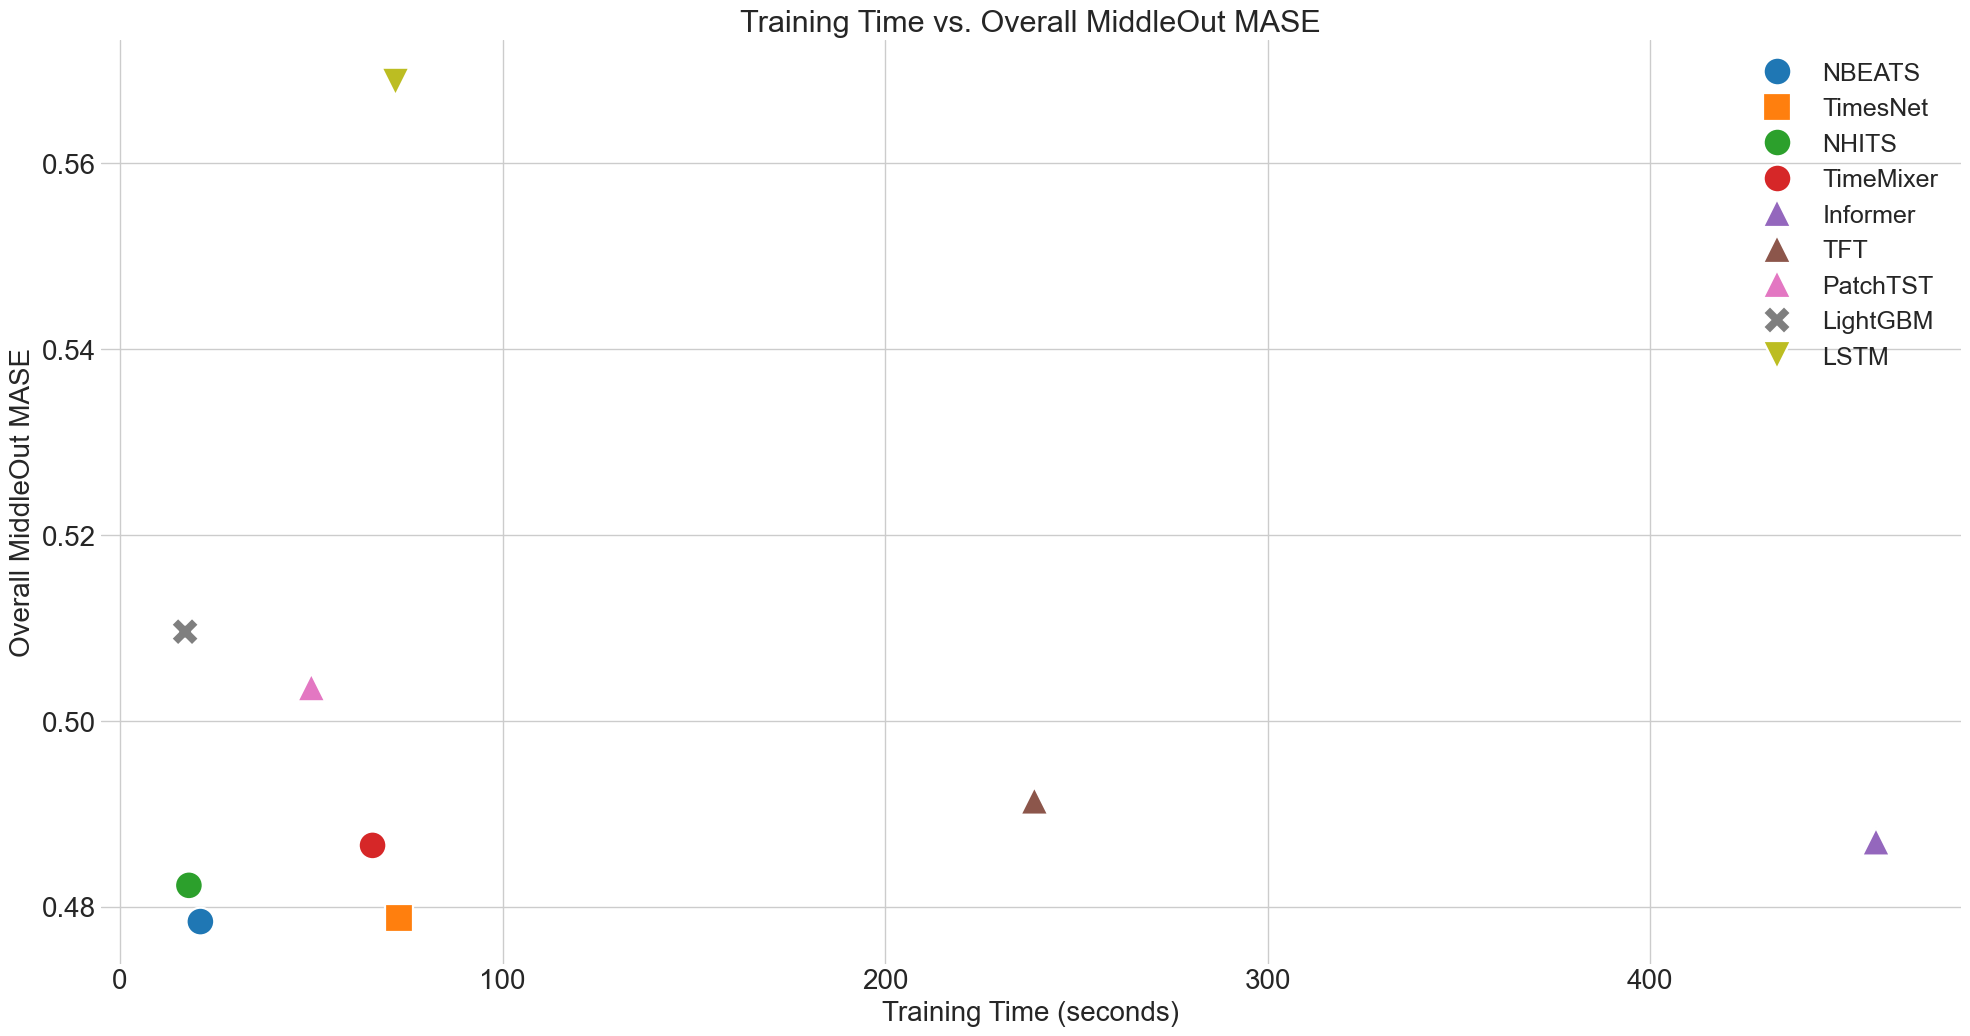

In [104]:
Y_hat_all = pd.concat([Y_hat_ml.iloc[:, :3], Y_hat_nn.drop(columns=['ds', 'unique_id'])], axis=1)
reconile_preds, reconile_results  = reconcile_eval(Y_hat_all)
preds_final = create_preds_dict(reconile_preds)

citerion = 'MASE'
recon_type = 'MiddleOut'
level = 'Overall'
index_name = level+' '+recon_type + ' '+ citerion
#eval_df = create_eval_df(reconile_results, criterion='MASE').filter(like='MiddleOut', axis=0).filter(like='Overall', axis=0)
eval_df = pd.DataFrame(create_eval_df(reconile_results, criterion=citerion).filter(like=recon_type, axis=0).filter(like=level, axis=0).reset_index().iloc[:, 2:], 
                            columns=create_eval_df(reconile_results, criterion=citerion).filter(like=recon_type, axis=0).filter(like=level, axis=0).reset_index().iloc[:, 2:].columns.tolist()).T.rename(columns={0: index_name})
# eval_df = pd.DataFrame(create_eval_df(reconile_results, criterion='MASE').filter(like='MiddleOut', axis=0).filter(like='Overall', axis=0).reset_index().iloc[:, 2:], columns=rcreate_eval_df(reconile_results, criterion='MASE').filter(like='MiddleOut', axis=0).filter(like='Overall', axis=0).reset_index().iloc[:, 2:].columns.tolist(), index=[index_name]).T
eval_df['Training Time'] = [time_dict[key] for key in eval_df.index]
eval_df.sort_values(index_name, inplace=True)
plt.figure(figsize=(24, 12))
sns.scatterplot(data=eval_df, x='Training Time', y=index_name, style=eval_df.index, hue=eval_df.index, s=400,  markers = ['o', 's', 'o', 'o', '^', '^', '^', 'X', 'v'])
plt.title(f'Training Time vs. {index_name}', fontsize=22)
plt.xlabel('Training Time (seconds)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(f'{index_name}', fontsize=20)
plt.legend(fontsize=18)
plt.show()

In [84]:
# horizon = 28
# models = [LSTM(h=horizon,                    # Forecast horizon
#                **lstm_params),
#           NBEATS(input_size=6 * horizon, h=horizon, stack_types = ['identity', 'trend', 'seasonality'],  batch_size=64,  random_seed=42,  max_steps=500),
#           NHITS(input_size=5 * horizon, h=horizon, batch_size=64,stack_types = ['identity']*3, learning_rate =1e-3, random_seed=42,  max_steps=400),
#           PatchTST(h=horizon, **PatchTST_params),
#           TimeMixer(h=horizon, n_series=1, random_seed=42, max_steps=1000, batch_size=128, learning_rate=0.001, input_size=6 * horizon, moving_avg=7,  d_model=32, d_ff=32, step_size=1),
#           TimesNet(h=horizon, hidden_size =16,  conv_hidden_size=7, random_seed=42, max_steps=400, batch_size=64, learning_rate=0.001, input_size=6 * horizon, step_size=1)]

# nf = NeuralForecast(models=models, freq='D', local_scaler_type='minmax')
# nf.fit(df=Y_train_df)
# Y_hat_df_neural = nf.predict().reset_index()
# reconcile_eval(Y_hat_df_neural)[1]

Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 17
Seed set to 42
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.1 M  | train
4 | context_adapter | Linear        | 42.1 K | train
5 | mlp_decoder     | MLP           | 3.6 K  | train
----------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.527     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.8 M  | train
-------------------------------------------------------
2.8 M     Trainable params
11.2 K    Non-trainable params
2.8 M     Total params
11.175    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.998    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 1.3 M  | train
-----------------------------------------------------------
1.3 M     Trainable params
3         Non-trainable params
1.3 M     Total params
5.064     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              | Type                 | Params | Mode 
--------------------------------------------------------------------
0  | loss              | MAE                  | 0      | train
1  | padder            | ConstantPad1d        | 0      | train
2  | scaler            | TemporalNorm         | 0      | train
3  | pdm_blocks        | ModuleList           | 273 K  | train
4  | preprocess        | SeriesDecomp         | 0      | train
5  | enc_embedding     | DataEmbedding_wo_pos | 2.5 K  | train
6  | normalize_layers  | ModuleList           | 4      | train
7  | predict_layers    | ModuleList           | 7.1 K  | train
8  | projection_layer  | Linear               | 33     | train
9  | out_res_layers    | ModuleList           | 35.5 K | train
10 | regression_layers | Modul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 128 K  | train
4 | enc_embedding  | DataEmbedding | 48     | train
5 | layer_norm     | LayerNorm     | 32     | train
6 | predict_linear | Linear        | 33.1 K | train
7 | projection     | Linear        | 17     | train
---------------------------------------------------------
161 K     Trainable params
0         Non-trainable params
161 K     Total params
0.646     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LSTM   NBEATS    NHITS  \
level                                    metric                              
Overall                                  RMSE     186.21   147.01   172.67   
                                         MAPE     0.1263   0.1129    0.116   
                                         MASE     0.5719   0.4866   0.5174   
country                                  RMSE    2831.71  2117.62  2967.05   
                                         MAPE     0.0524   0.0387   0.0515   
                                         MASE     0.2871   0.2106   0.2903   
country/state_id                         RMSE    1186.65   835.78  1099.18   
                                         MAPE      0.064   0.0474   0.0585   
                                         MASE     0.3504   0.2484   0.3175   
country/state_id/store_id                RMSE     397.17   315.74    368.1   
                                         MAPE     0.0704   0.0595   0.0672   
                                         MASE     0.3725   0.3068   0.3612   
country/state_id/store_id/cat_id         RMSE     166.09   134.23   148.34   
                                         MAPE     0.1027   0.0874   0.0942   
                                         MASE     0.5047   0.4163   0.4599   
country/state_id/store_id/cat_id/dept_id RMSE      84.03    70.71    75.55   
                                         MAPE     0.1481   0.1354   0.1357   
                                         MASE     0.6427   0.5566   0.5761   

                                                PatchTST TimeMixer TimesNet  \
level                                    metric                               
Overall                                  RMSE     153.09     147.3   142.79   
                                         MAPE     0.1168     0.116   0.1127   
                                         MASE     0.5066    0.4876   0.4809   
country                                  RMSE    2249.44   2027.68  1899.41   
                                         MAPE     0.0402     0.038   0.0342   
                                         MASE     0.2201    0.2006   0.1847   
country/state_id                         RMSE     946.91    868.53   816.75   
                                         MAPE     0.0506    0.0523   0.0453   
                                         MASE     0.2659    0.2678   0.2393   
country/state_id/store_id                RMSE     318.26    319.66   303.12   
                                         MAPE     0.0581    0.0605   0.0557   
                                         MASE     0.2983    0.3065   0.2899   
country/state_id/store_id/cat_id         RMSE     136.78    135.23   132.88   
                                         MAPE     0.0902    0.0884   0.0852   
                                         MASE     0.4313    0.4146   0.4077   
country/state_id/store_id/cat_id/dept_id RMSE      72.52     70.07    70.15   
                                         MAPE     0.1406    0.1395   0.1366   
                                         MASE     0.5831    0.5583   0.5542   

                                                LSTM/BottomUp NBEATS/BottomUp  \
level                                    metric                                 
Overall                                  RMSE           184.7          147.61   
                                         MAPE          0.1263          0.1133   
                                         MASE          0.5722           0.489   
country                                  RMSE         2771.67         2034.08   
                                         MAPE          0.0491           0.037   
                                         MASE          0.2712          0.2014   
country/state_id                         RMSE         1126.34          861.48   
                                         MAPE          0.0598          0.0501   
                                         MASE          0.3245          0.2636   
country/state_id/st

### Holiday and Events

In [53]:
exog_dict = {'hist_exog_list': ['snap_ca',	'Holiday_related']}
models_dict_exog = {}
#models_dict_exog['LSTM'] = [LSTM(h=horizon,  **lstm_params, **exog_dict)]
models_dict_exog['NBEATSx'] = [NBEATSx(input_size=6 * horizon, h=horizon, stack_types = ['identity', 'trend', 'seasonality'],  batch_size=64,  random_seed=42,  max_steps=500, **exog_dict, futr_exog_list=['snap_ca',	'Holiday_related'])]

# models_dict['Informer'] = [Informer(h=horizon, **best_params_informer)]

Seed set to 42


In [54]:
horizon = 28
Y_hat_nn_exog = Y_test_df.drop(columns='y').copy()
for key, value in models_dict_exog.items():
    nf = NeuralForecast(models=value, freq='D', local_scaler_type='minmax')
    nf.fit(df=Y_train_exog)
    Y_hat_preds = nf.predict(futr_df=exog_df).reset_index()
    Y_hat_nn_exog[key] = Y_hat_preds[key].values
Y_hat_nn_exog.reset_index(drop=True, inplace=True)
Y_hat_nn_exog['unique_id'] = Y_hat_preds['unique_id']    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.9 M  | train
-------------------------------------------------------
3.9 M     Trainable params
11.2 K    Non-trainable params
3.9 M     Total params
15.648    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:865: UserWarning: Dropped 214,890 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [55]:
reconcile_eval(Y_hat_nn_exog)[1]

NBEATSx NBEATSx/BottomUp  \
level                                    metric                             
Overall                                  RMSE     294.22           309.28   
                                         MAPE     0.1705           0.1737   
                                         MASE     0.7938           0.8124   
country                                  RMSE    6467.89          6459.99   
                                         MAPE     0.1401           0.1369   
                                         MASE     0.7532           0.7417   
country/state_id                         RMSE    1939.97          2216.71   
                                         MAPE      0.117           0.1354   
                                         MASE     0.6241           0.7284   
country/state_id/store_id                RMSE     640.77           689.13   
                                         MAPE     0.1303           0.1405   
                                         MASE     0.6814           0.7419   
country/state_id/store_id/cat_id         RMSE     231.85           245.53   
                                         MAPE     0.1525           0.1595   
                                         MASE      0.746           0.7862   
country/state_id/store_id/cat_id/dept_id RMSE     112.71           112.71   
                                         MAPE     0.1867           0.1867   
                                         MASE     0.8382           0.8382   

                                                NBEATSx/TopDown_method-forecast_proportions  \
level                                    metric                                               
Overall                                  RMSE                                        311.93   
                                         MAPE                                        0.1777   
                                         MASE                                         0.824   
country                                  RMSE                                       6467.89   
                                         MAPE                                        0.1401   
                                         MASE                                        0.7532   
country/state_id                         RMSE                                       2235.68   
                                         MAPE                                        0.1377   
                                         MASE                                        0.7307   
country/state_id/store_id                RMSE                                        696.84   
                                         MAPE                                        0.1436   
                                         MASE                                        0.7466   
country/state_id/store_id/cat_id         RMSE                                        248.36   
                                         MAPE                                        0.1642   
                                         MASE                                        0.8004   
country/state_id/store_id/cat_id/dept_id RMSE                                        113.79   
                                         MAPE                                        0.1906   
                                         MASE                                        0.8502   

                                                NBEATSx/MiddleOut_middle_level-country/state_id/store_id_top_down_method-forecast_proportions  \
level                                    metric                                                                                                 
Overall                                  RMSE                                               288.31                                              
                                         MAPE                                               0.1678                                              
                           

In [ ]:
horizon = 28
models = [LSTM(h=horizon,                    # Forecast horizon
               **lstm_params,  futr_exog_list = ['snap_ca',	'Holiday_related']),
          NBEATSx(input_size=6 * horizon, h=horizon, stack_types = ['identity', 'trend', 'seasonality'],  batch_size=64,  random_seed=42,  max_steps=500,  futr_exog_list = ['snap_ca',	'Holiday_related']),
          NHITS(input_size=5 * horizon, h=horizon, batch_size=64,stack_types = ['identity']*3, learning_rate =1e-3, random_seed=42,  max_steps=400,  futr_exog_list = ['snap_ca',	'Holiday_related']),
          PatchTST(h=horizon, **PatchTST_params,  futr_exog_list = ['snap_ca',	'Holiday_related']),
          TimeMixer(h=horizon, n_series=1, random_seed=42, max_steps=1000, batch_size=128, learning_rate=0.001, input_size=6 * horizon, moving_avg=7,  d_model=32, d_ff=32, step_size=1,  futr_exog_list = ['snap_ca',	'Holiday_related']),
          TimesNet(h=horizon, hidden_size =16,  conv_hidden_size=7, random_seed=42, max_steps=400, batch_size=64, learning_rate=0.001, input_size=6 * horizon, step_size=1),  futr_exog_list = ['snap_ca',	'Holiday_related']]


nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_exog)
Y_hat_df_neural_cov = nf.predict(futr_df=exog_df).reset_index()
reconcile_eval(Y_hat_df_neural_cov)[1]

In [219]:
horizon = 28
models = [LSTM(h=horizon,                    # Forecast horizon
               **lstm_params, futr_exog_list = ['snap_ca',	'Holiday_related']),
          NBEATSx(input_size=6 * horizon, h=horizon, batch_size=128,  activation='ReLU', random_seed=42, max_steps=500,  futr_exog_list = ['snap_ca',	'Holiday_related']),
          NHITS(input_size=5 * horizon, h=horizon, batch_size=64,  random_seed=42,  max_steps=500,  futr_exog_list = ['snap_ca',	'Holiday_related']), 
          ] #,

nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_exog)
Y_hat_df_neural = nf.predict(futr_df=exog_df).reset_index()
reconcile_eval(Y_hat_df_neural)[1]

Seed set to 42
Seed set to 42
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.1 M  | train
4 | context_adapter | Linear        | 50.0 K | train
5 | mlp_decoder     | MLP           | 4.6 K  | train
----------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.562     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.4 M  | train
-------------------------------------------------------
3.4 M     Trainable params
11.2 K    Non-trainable params
3.4 M     Total params
13.583    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.1 M  | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.374    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:865: UserWarning: Dropped 214,890 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\49152\anaconda3\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LSTM NBEATSx    NHITS  \
level                                    metric                             
Overall                                  RMSE     195.09  137.77    172.3   
                                         MAPE     0.1298  0.1158   0.1336   
                                         MASE     0.5863   0.486    0.594   
country                                  RMSE    2983.89  1595.9  2582.59   
                                         MAPE     0.0542  0.0258    0.045   
                                         MASE     0.2961  0.1388   0.2516   
country/state_id                         RMSE    1235.09  763.98   995.11   
                                         MAPE     0.0659  0.0435   0.0553   
                                         MASE     0.3557   0.228   0.2938   
country/state_id/store_id                RMSE     425.18  306.37   362.29   
                                         MAPE     0.0755  0.0587   0.0686   
                                         MASE     0.4036  0.2992   0.3577   
country/state_id/store_id/cat_id         RMSE     172.67  131.51   155.52   
                                         MAPE     0.1037  0.0873    0.107   
                                         MASE     0.5084  0.4124    0.518   
country/state_id/store_id/cat_id/dept_id RMSE      87.41    68.7    82.66   
                                         MAPE     0.1526  0.1405   0.1589   
                                         MASE     0.6598  0.5602   0.6781   

                                                LSTM/BottomUp  \
level                                    metric                 
Overall                                  RMSE          190.76   
                                         MAPE          0.1297   
                                         MASE          0.5856   
country                                  RMSE         2727.18   
                                         MAPE          0.0506   
                                         MASE          0.2764   
country/state_id                         RMSE         1149.53   
                                         MAPE          0.0614   
                                         MASE          0.3287   
country/state_id/store_id                RMSE          422.64   
                                         MAPE          0.0749   
                                         MASE          0.3993   
country/state_id/store_id/cat_id         RMSE          174.19   
                                         MAPE           0.104   
                                         MASE          0.5106   
country/state_id/store_id/cat_id/dept_id RMSE           87.41   
                                         MAPE          0.1526   
                                         MASE          0.6598   

                                                NBEATSx/BottomUp  \
level                                    metric                    
Overall                                  RMSE             141.77   
                                         MAPE             0.1159   
                                         MASE              0.487   
country                                  RMSE            1815.37   
                                         MAPE             0.0313   
                                         MASE             0.1678   
country/state_id                         RMSE             824.66   
                                         MAPE             0.0486   
                                         MASE             0.2526   
country/state_id/store_id                RMSE             310.62   
                                         MAPE             0.0585   
                                         MASE             0.3016   
country/state_id/store_id/cat_id         RMSE             131.89   
                                         MAPE              0.087   
                                         MASE              0.412   
country/state_id/store_id/cat_id/dept_id RMSE         

In [220]:
reconcile_eval(Y_hat_df_neural)[1]

LSTM NBEATSx    NHITS  \
level                                    metric                             
Overall                                  RMSE     195.09  137.77    172.3   
                                         MAPE     0.1298  0.1158   0.1336   
                                         MASE     0.5863   0.486    0.594   
country                                  RMSE    2983.89  1595.9  2582.59   
                                         MAPE     0.0542  0.0258    0.045   
                                         MASE     0.2961  0.1388   0.2516   
country/state_id                         RMSE    1235.09  763.98   995.11   
                                         MAPE     0.0659  0.0435   0.0553   
                                         MASE     0.3557   0.228   0.2938   
country/state_id/store_id                RMSE     425.18  306.37   362.29   
                                         MAPE     0.0755  0.0587   0.0686   
                                         MASE     0.4036  0.2992   0.3577   
country/state_id/store_id/cat_id         RMSE     172.67  131.51   155.52   
                                         MAPE     0.1037  0.0873    0.107   
                                         MASE     0.5084  0.4124    0.518   
country/state_id/store_id/cat_id/dept_id RMSE      87.41    68.7    82.66   
                                         MAPE     0.1526  0.1405   0.1589   
                                         MASE     0.6598  0.5602   0.6781   

                                                LSTM/BottomUp  \
level                                    metric                 
Overall                                  RMSE          190.76   
                                         MAPE          0.1297   
                                         MASE          0.5856   
country                                  RMSE         2727.18   
                                         MAPE          0.0506   
                                         MASE          0.2764   
country/state_id                         RMSE         1149.53   
                                         MAPE          0.0614   
                                         MASE          0.3287   
country/state_id/store_id                RMSE          422.64   
                                         MAPE          0.0749   
                                         MASE          0.3993   
country/state_id/store_id/cat_id         RMSE          174.19   
                                         MAPE           0.104   
                                         MASE          0.5106   
country/state_id/store_id/cat_id/dept_id RMSE           87.41   
                                         MAPE          0.1526   
                                         MASE          0.6598   

                                                NBEATSx/BottomUp  \
level                                    metric                    
Overall                                  RMSE             141.77   
                                         MAPE             0.1159   
                                         MASE              0.487   
country                                  RMSE            1815.37   
                                         MAPE             0.0313   
                                         MASE             0.1678   
country/state_id                         RMSE             824.66   
                                         MAPE             0.0486   
                                         MASE             0.2526   
country/state_id/store_id                RMSE             310.62   
                                         MAPE             0.0585   
                                         MASE             0.3016   
country/state_id/store_id/cat_id         RMSE             131.89   
                                         MAPE              0.087   
                                         MASE              0.412   
country/state_id/store_id/cat_id/dept_id RMSE         

## Final Evaluation

In [ ]:
#Y_hat_nn.to_csv('data/results/M5/Y_hat_nn4.csv', index=False)
#Y_hat_ml_covs.to_csv('data/results/M5/Y_hat_ml_covs.csv', index=False)
#Y_hat_ml.to_csv('data/results/M5/Y_hat_ml.csv', index=False)
#Y_hat_df_neural = pd.read_csv('data/results/M5/Y_hat_df_neural.csv', parse_dates=['ds'])
#Y_hat_df_neural = pd.read_csv('data/results/M5/Y_hat_nn.csv', parse_dates=['ds'])
Y_hat_df_neural = pd.read_csv('data/M5/Y_hat_nn.csv', parse_dates=['ds'])

Y_hat_ml= pd.read_csv('data/results/M5/Y_hat_ml_covs.csv')
Y_hat_stats = pd.read_csv('data/results/M5/Y_hat_stats.csv')

In [73]:
Y_hat_eval = pd.merge(Y_test_df, Y_hat_df_neural, on=['unique_id', 'ds'], how='left')

In [74]:
Y_hat_final = pd.concat([Y_hat_stats, Y_hat_ml.drop(columns=['ds', 'unique_id']), Y_hat_df_neural.drop(columns=['ds', 'unique_id'])], axis=1)
#Y_hat_final.to_csv('data/results/M5/Y_hat_final.csv', index=True)
Y_hat_final = pd.read_csv('data/results/M5/Y_hat_final.csv', index_col=0)
Y_hat_final

unique_id          ds  SeasonalNaive  \
0                                   USA  2016-03-28        37360.0   
1                                   USA  2016-03-29        35475.0   
2                                   USA  2016-03-30        34786.0   
3                                   USA  2016-03-31        34003.0   
4                                   USA  2016-04-01        45611.0   
...                                 ...         ...            ...   
3187  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-20          120.0   
3188  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-21           98.0   
3189  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-22          198.0   
3190  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-23          186.0   
3191  USA/WI/WI_3/HOUSEHOLD/HOUSEHOLD_2  2016-04-24          196.0   

      SeasonalNaive-lo-95  SeasonalNaive-hi-95  HistoricAverage  \
0            19681.887000          55038.11300     34223.758000   
1            17796.887000          53153.11300     34223.758000   
2            17107.887000          52464.11300     34223.758000   
3            16324.888000          51681.11300     34223.758000   
4            27932.887000          63289.11300     34223.758000   
...                   ...                  ...              ...   
3187            22.419859            217.58014       110.461006   
3188             0.419858            195.58014       110.461006   
3189           100.419860            295.58014       110.461006   
3190            88.419860            283.58014       110.461006   
3191            98.419860            293.58014       110.461006   

      HistoricAverage-lo-95  HistoricAverage-hi-95          RWD    RWD-lo-95  \
0              19941.998000            48505.52000  46367.29000  34776.44500   
1              19941.998000            48505.52000  46374.57400  29978.30000   
2              19941.998000            48505.52000  46381.86300  26295.28700   
3              19941.998000            48505.52000  46389.15000  23189.02300   
4              19941.998000            48505.52000  46396.43800  20451.04100   
...                     ...                    ...          ...          ...   
3187              51.583878              169.33813    196.61147    -90.39970   
3188              51.583878              169.33813    196.63695    -96.36935   
3189              51.583878              169.33813    196.66241   -102.22480   
3190              51.583878              169.33813    196.68790   -107.97264   
3191              51.583878              169.33813    196.71338   -113.61890   

      ...  HoltWinters-hi-95  LGBMRegressor         LSTM       NBEATS  \
0     ...        46506.00400   36643.162400  36997.94500  35048.90200   
1     ...        44175.43000   33862.192927  35574.27000  34138.44500   
2     ...        44390.14500   33627.135183  35631.52300  34512.38700   
3     ...        45005.71500   34686.080544  36428.00800  35356.77700   
4     ...        48199.78500   42061.192233  41807.41400  41407.20700   
...   ...                ...            ...          ...          ...   
3187  ...          178.14790     122.635265    118.70412    119.66218   
3188  ...          183.73140     121.994526    122.04640    121.18126   
3189  ...          208.97163     143.692607    144.86127    140.83992   
3190  ...          225.73006     177.907120    186.54489    186.52654   
3191  ...          215.20958     163.235710    175.63794    179.03418   

            NHITS     PatchTST    TimeMixer     TimesNet      Informer  \
0     37671.68400  36732.41400  36608.85000  35537.82400  37040.020000   
1     35016.59400  35100.97700  34477.34000  34618.24000  34789.027000   
2     35373.61700  35436.97000  34668.07000  35065.74600  34915.664000   
3     35823.09400  36968.36000  37506.58000  36305.82000  36061.900000   
4     41298.34400  41973.98000  40914.32000  40667.15200  41118.016000   
...           ...          ...          ...          ...           ...   
3187    129.91570    123.944

In [75]:
Y_hat_final_models = Y_hat_final.loc[:, ['ds', 'unique_id',  'SeasonalNaive', 'HoltWinters', 'AutoARIMA',  'LGBMRegressor', 'LSTM',  'TimesNet','NBEATS',  'PatchTST']]
Y_hat_final_models['ds'] = pd.to_datetime(Y_hat_final_models['ds'])

In [76]:
reconile_preds, reconile_results  = reconcile_eval(Y_hat_final_models)
preds_final = create_preds_dict(reconile_preds)
reconile_preds.reset_index(inplace=True)
reconile_results

SeasonalNaive HoltWinters  \
level                                    metric                             
Overall                                  RMSE          261.86      212.45   
                                         MAPE          0.1765      0.1517   
                                         MASE          0.7817      0.6645   
country                                  RMSE         3947.48     3023.24   
                                         MAPE          0.0735      0.0572   
                                         MASE          0.4047      0.3045   
country/state_id                         RMSE         1578.26     1299.93   
                                         MAPE          0.0876      0.0723   
                                         MASE          0.4758      0.3929   
country/state_id/store_id                RMSE          572.16      455.31   
                                         MAPE          0.1027      0.0792   
                                         MASE          0.5521      0.4356   
country/state_id/store_id/cat_id         RMSE          234.15      184.54   
                                         MAPE          0.1382      0.1023   
                                         MASE          0.6664      0.4999   
country/state_id/store_id/cat_id/dept_id RMSE          120.33      102.95   
                                         MAPE          0.2087       0.188   
                                         MASE          0.8824      0.7845   

                                                AutoARIMA LGBMRegressor  \
level                                    metric                           
Overall                                  RMSE      209.95        157.01   
                                         MAPE      0.1378        0.1144   
                                         MASE      0.6144        0.5244   
country                                  RMSE     3520.74       2148.09   
                                         MAPE      0.0644        0.0373   
                                         MASE      0.3543        0.2071   
country/state_id                         RMSE     1304.31        923.31   
                                         MAPE      0.0695        0.0502   
                                         MASE      0.3845         0.259   
country/state_id/store_id                RMSE      433.72        322.25   
                                         MAPE      0.0757         0.057   
                                         MASE      0.4211        0.3046   
country/state_id/store_id/cat_id         RMSE      190.42        145.09   
                                         MAPE      0.1122        0.0928   
                                         MASE      0.5549        0.4569   
country/state_id/store_id/cat_id/dept_id RMSE       92.15         77.23   
                                         MAPE      0.1616        0.1356   
                                         MASE      0.6811        0.6007   

                                                    LSTM TimesNet   NBEATS  \
level                                    metric                              
Overall                                  RMSE     186.21    143.0   145.17   
                                         MAPE     0.1263   0.1127   0.1118   
                                         MASE     0.5719    0.481   0.4825   
country                                  RMSE    2831.71  1908.52  1906.99   
                                         MAPE     0.0524   0.0344   0.0341   
                                         MASE     0.2871   0.1857   0.1851   
country/state_id                         RMSE    1186.65   819.08   859.52   
                                         MAPE      0.064   0.0453   0.0486   
                                         MASE     0.3504   0.2395   0.2523   
country/state_id/store_id                RMSE     397.17    303.5   311.87   
                                         MAPE     0.0704   0.0557   0.

In [78]:
# with pd.ExcelWriter('data/results/M5/eval_results.xlsx') as writer:
#     for criterion in ['RMSE', 'MAPE', 'MASE']:
#         eval_df = create_eval_df(reconile_results, criterion=criterion)
#         eval_df.to_excel(writer, sheet_name=criterion, index=True)

In [79]:
# with open('data/results/M5/preds_final.pkl', 'wb') as f:
#     pickle.dump(preds_final, f)

In [77]:
create_eval_df(reconile_results, criterion='MAPE')

SeasonalNaive HoltWinters AutoARIMA LGBMRegressor   LSTM  \
level      type                                                                 
Overall    BottomUp          17.65       15.17     13.74         11.63  12.63   
           TopDown           17.65       15.36     13.51         11.71  12.83   
           MiddleOut         17.65       15.15      13.5         11.28   12.6   
           MinTrace          17.65       15.94     16.07         16.86  14.03   
           Optimal           17.65       15.28     13.86         12.23  12.96   
Country    BottomUp           7.35        5.78      6.68           4.9   4.91   
           TopDown            7.35        5.72      6.44          3.73   5.24   
           MiddleOut          7.35         5.9      6.23          2.93   4.98   
           MinTrace           7.35        5.75      6.42          3.24   5.23   
           Optimal            7.35        5.77       6.5          3.35   5.06   
State      BottomUp           8.76        7.14      7.13          5.65   5.98   
           TopDown            8.76        7.38      6.94          5.46   6.33   
           MiddleOut          8.76        7.08      6.84          4.32   5.87   
           MinTrace           8.76        7.26      6.94          4.72   6.22   
           Optimal            8.76        7.16       7.0          4.53   6.03   
Store      BottomUp          10.27        7.87      7.94          6.53   7.07   
           TopDown           10.27        8.12      7.76          6.54   7.33   
           MiddleOut         10.27        7.92      7.57           5.7   7.04   
           MinTrace          10.27         8.0      7.71          5.83   7.24   
           Optimal           10.27        7.88      7.77          5.58    7.1   
Category   BottomUp          13.82       10.24     10.92          9.65  10.31   
           TopDown           13.82       10.37     10.89          9.79  10.49   
           MiddleOut         13.82       10.29     10.82          9.25  10.25   
           MinTrace          13.82       10.42     11.08         10.61  10.84   
           Optimal           13.82        10.3     10.51          8.99  10.44   
Department BottomUp          20.87        18.8     16.16         13.56  14.81   
           TopDown           20.87       19.02     15.84         13.66  15.01   
           MiddleOut         20.87       18.74     15.89         13.36   14.8   
           MinTrace          20.87       19.96     19.93         21.83  16.82   
           Optimal           20.87       18.96     16.57         15.03   15.3   

                     TimesNet NBEATS PatchTST  
level      type                                
Overall    BottomUp     11.29  11.22    11.72  
           TopDown      11.28   11.2    11.69  
           MiddleOut    11.25  11.14    11.66  
           MinTrace     11.71  11.97    12.93  
           Optimal      11.38  11.29    11.88  
Country    BottomUp      3.57   3.35     4.02  
           TopDown       3.44   3.41     4.02  
           MiddleOut     3.39    3.1     3.84  
           MinTrace      3.42   3.31     3.96  
           Optimal       3.42   3.19     3.85  
State      BottomUp      4.73   4.93     5.19  
           TopDown       4.54   4.99     5.04  
           MiddleOut     4.54   4.77     4.99  
           MinTrace      4.53   4.92     5.02  
           Optimal       4.55   4.84     5.04  
Store      BottomUp       5.7    6.0     5.96  
           TopDown       5.61   6.08      5.9  
           MiddleOut     5.57   5.91     5.81  
           MinTrace       5.6   6.06     5.91  
           Optimal       5.61   5.95     5.85  
Category   BottomUp      8.52   8.75      9.1  
           TopDown       8.48   8.75     9.15  
           MiddleOut     8.45   8.62     9.01  
           MinTrace      8.53   9.03     9.52  
           Optimal       8.45   8.72     9.13  
Department BottomUp     13.67   13.4    14.06  
           TopDown      13.69  13.35     14.0  
           MiddleOut    13.66  13.35

In [81]:
pd.DataFrame(create_eval_df(reconile_results, criterion=citerion).filter(like=recon_type, axis=0).filter(like="Overall", axis=0).reset_index().iloc[:, 2:], 
                            columns=create_eval_df(reconile_results, criterion=citerion).filter(like=recon_type, axis=0).filter(like="Overall", axis=0).reset_index().iloc[:, 2:].columns.tolist()).T

0
SeasonalNaive  0.7817
HoltWinters    0.6679
AutoARIMA      0.5987
LGBMRegressor  0.5096
LSTM           0.5688
TimesNet       0.4788
NBEATS         0.4784
PatchTST       0.5036

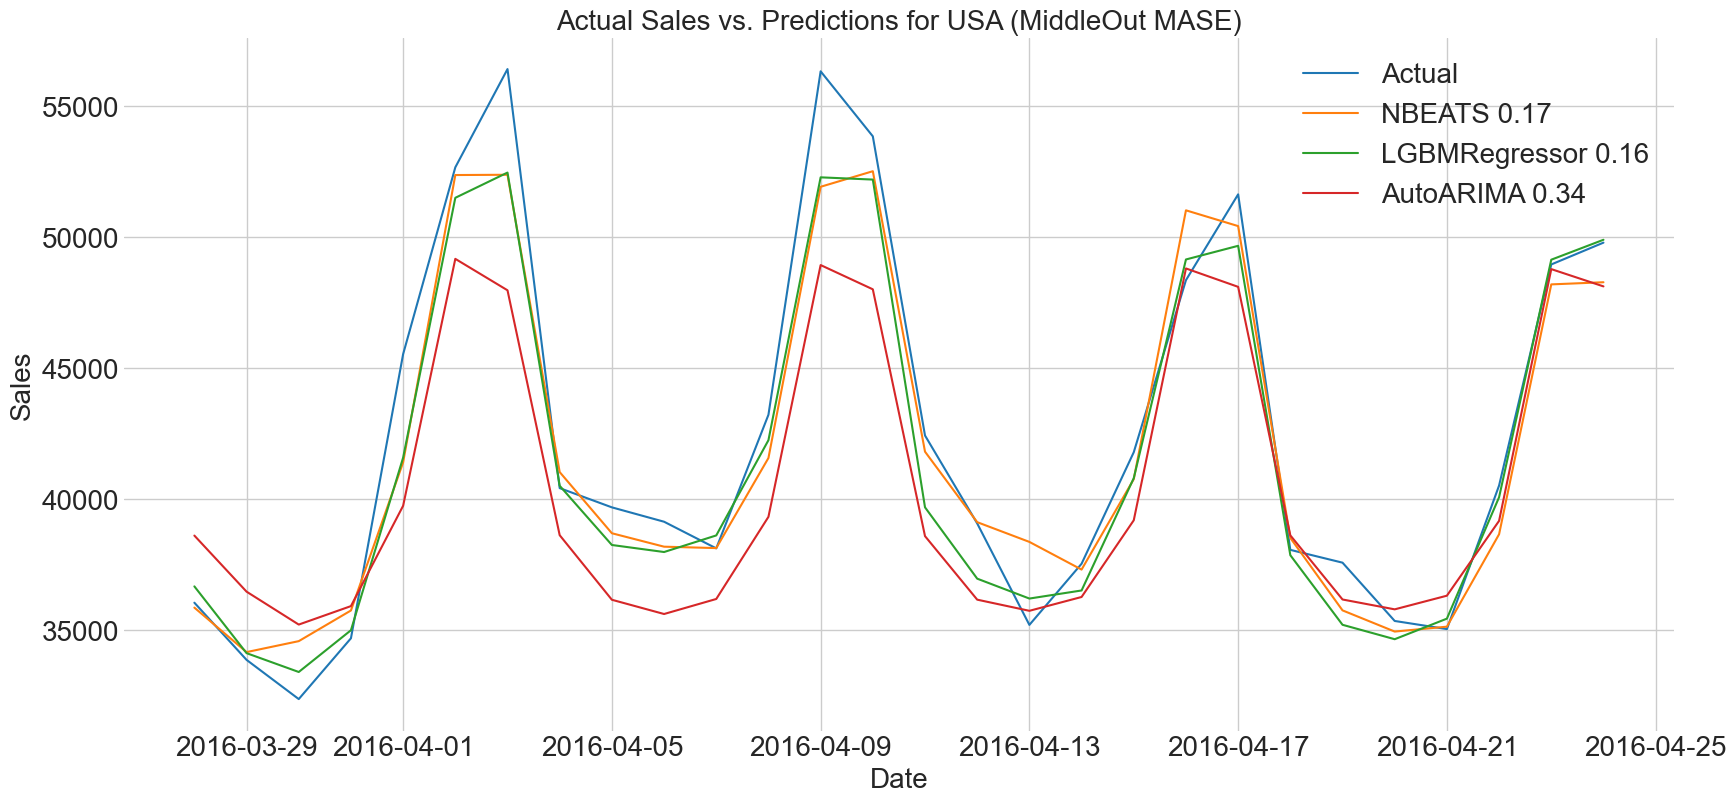

In [89]:
reconile_preds, reconile_results  = reconcile_eval(Y_hat_final_models)
preds_final = create_preds_dict(reconile_preds)
reconile_preds.reset_index(inplace=True)
reconile_results

citerion = 'MASE'
recon_type = 'MiddleOut'
level = 'Country'
index_name = recon_type + ' '+ citerion

eval_df = pd.DataFrame(create_eval_df(reconile_results, criterion=citerion).filter(like=recon_type, axis=0).filter(like="Overall", axis=0).reset_index().iloc[:, 2:], 
                            columns=create_eval_df(reconile_results, criterion=citerion).filter(like=recon_type, axis=0).filter(like="Overall", axis=0).reset_index().iloc[:, 2:].columns.tolist()).T.rename(columns={0: index_name}).sort_values(by=index_name)

eval_df_level = pd.DataFrame(create_eval_df(reconile_results, criterion=citerion).filter(like=recon_type, axis=0).filter(like=level, axis=0).reset_index().iloc[:, 2:], 
                            columns=create_eval_df(reconile_results, criterion=citerion).filter(like=recon_type, axis=0).filter(like=level, axis=0).reset_index().iloc[:, 2:].columns.tolist()).T.rename(columns={0: index_name}).sort_values(by=index_name)

best_overall = eval_df.index[0]
best_lvl = eval_df_level.index[0]

error1 = eval_df_level[eval_df_level.index == best_overall].values[0][0]
error2 = eval_df_level[eval_df_level.index == best_lvl].values[0][0]
error3 = eval_df_level[eval_df_level.index == "AutoARIMA"].values[0][0]

plot_df = preds_final['MiddleOut'].loc[:, ('unique_id', 'ds', 'AutoARIMA', best_overall, best_lvl)]
plot_df['y'] = Y_test_df['y'].values
plot_df.rename(columns = {'y': 'Actual'}, inplace=True)
country_df = plot_df[plot_df['unique_id'] == 'USA']
fig = plt.figure(figsize=(20, 9))
plt.plot(country_df.ds, country_df.Actual, label='Actual')
plt.plot(country_df.ds, country_df[best_overall], label=f'{best_overall} {error1:.2f}')
plt.plot(country_df.ds, country_df[best_lvl], label=f'{best_lvl} {error2:.2f}')
plt.plot(country_df.ds, country_df.AutoARIMA, label=f'AutoARIMA {error3:.2f}')
plt.title(f'Actual Sales vs. Predictions for {country_df.unique_id.iloc[0]} ({index_name})', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Sales', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Generated Figures in the Thesis

In [63]:
#reconile_all_results.to_excel('data/models/reconile_all_results.xlsx', index=True)

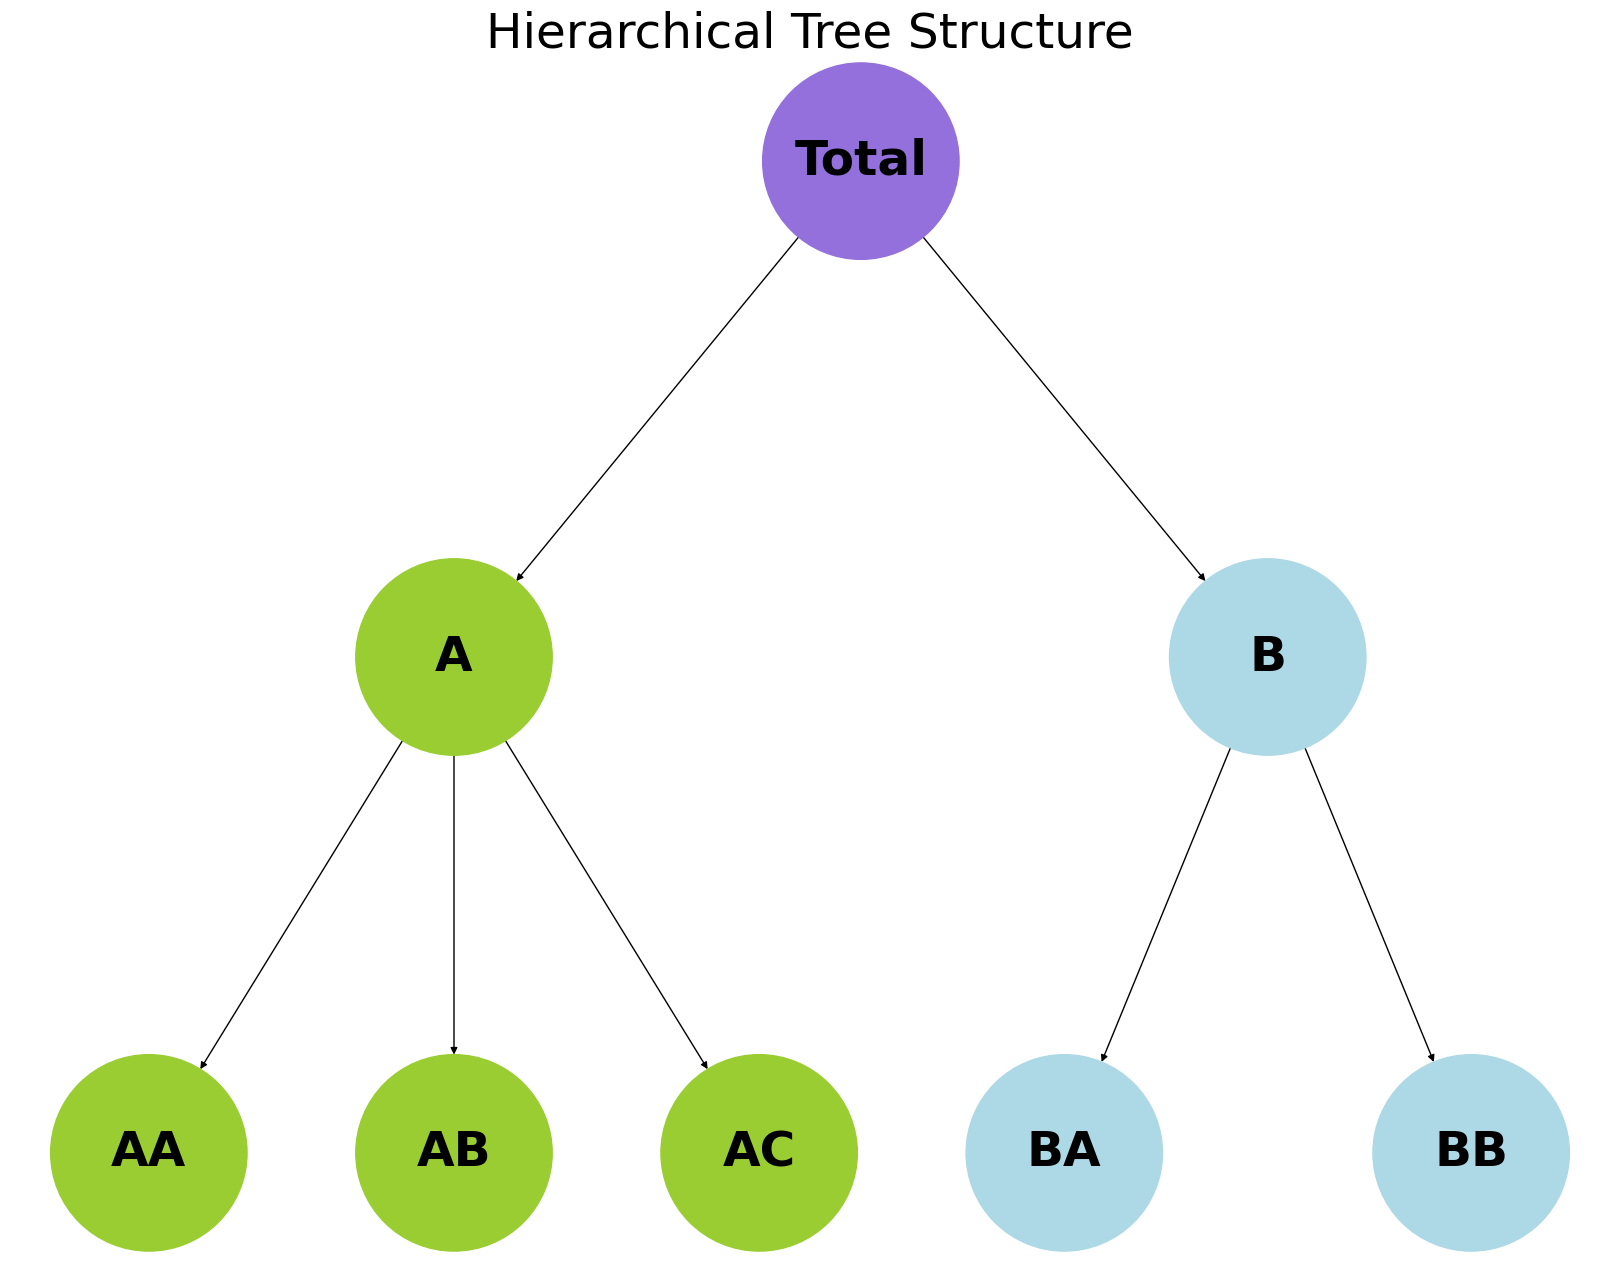

In [48]:
import matplotlib.pyplot as plt
import networkx as nx

# Initialize the directed graph
G = nx.DiGraph()

# Define the nodes and edges for the hierarchical structure
G.add_node("Total", pos=(0.5, 1), color="mediumpurple")
G.add_node("A", pos=(0.3, 0.7), color="yellowgreen")
G.add_node("B", pos=(0.7, 0.7), color="lightblue")
G.add_node("AA", pos=(0.15, 0.4), color="yellowgreen")
G.add_node("AB", pos=(0.3, 0.4), color="yellowgreen")
G.add_node("AC", pos=(0.45, 0.4), color="yellowgreen")
G.add_node("BA", pos=(0.6, 0.4), color="lightblue")
G.add_node("BB", pos=(0.8, 0.4), color="lightblue")

# Define edges to create the tree structure
G.add_edges_from([("Total", "A"), ("Total", "B"),
                  ("A", "AA"), ("A", "AB"), ("A", "AC"),
                  ("B", "BA"), ("B", "BB")])

# Extract positions for each node
pos = nx.get_node_attributes(G, 'pos')
node_colors = [G.nodes[node]['color'] for node in G.nodes]

# Draw the graph
plt.figure(figsize=(16, 12))
nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes},
        node_color=node_colors, node_size=20000, edge_color="black", font_size=35, font_weight="bold", font_color="Black")

# Set title and remove axes
plt.title("Hierarchical Tree Structure", fontsize=35)
plt.axis('off')
plt.show()


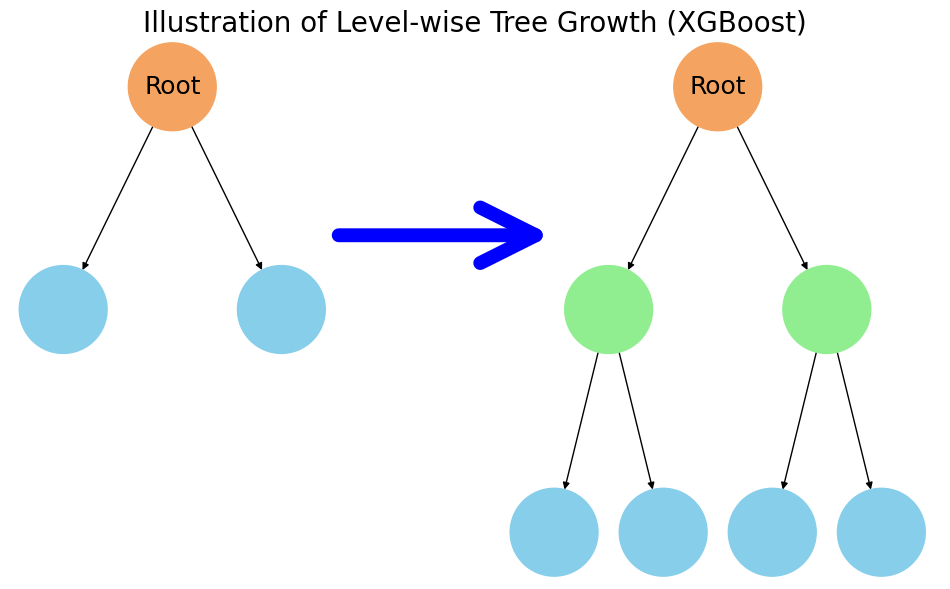

In [59]:
# Create the first tree (simple tree)
G1 = nx.DiGraph()
G1.add_node(1, pos=(0.5, 1), color = "sandybrown")
G1.add_node(2, pos=(0.3, 0.7))
G1.add_node(3, pos=(0.7, 0.7))
G1.add_edge(1, 2)
G1.add_edge(1, 3)

pos1 = nx.get_node_attributes(G1, 'pos')
node_colors_1 = ['sandybrown', 'skyblue', 'skyblue']

# Create the second tree (expanded tree)
G2 = nx.DiGraph()
G2.add_node(1, pos=(1.5, 1))
G2.add_node(2, pos=(1.3, 0.7))
G2.add_node(3, pos=(1.7, 0.7))
G2.add_node(4, pos=(1.2, 0.4))
G2.add_node(5, pos=(1.4, 0.4))
G2.add_node(6, pos=(1.6, 0.4))
G2.add_node(7, pos=(1.8, 0.4))
G2.add_edges_from([(1, 2), (1, 3), (2, 4), (2, 5), (3, 6), (3, 7)])

pos2 = nx.get_node_attributes(G2, 'pos')
node_colors_2 = ['sandybrown', 'lightgreen', 'lightgreen', 'skyblue', 'skyblue', 'skyblue', 'skyblue']

# Plot the combined trees
fig, ax = plt.subplots(figsize=(12, 7))

# Draw the first tree
nx.draw(G1, pos1, ax=ax, with_labels=False, node_color=node_colors_1, node_size=4000, edge_color="black")
nx.draw_networkx_labels(G1, pos1, labels={1: 'Root', 2: '', 3: ''}, font_color="black", font_size=18)

# Draw the second tree
nx.draw(G2, pos2, ax=ax, with_labels=False, node_color=node_colors_2, node_size=4000, edge_color="black")
nx.draw_networkx_labels(G2, pos2, labels={1: 'Root', 2: '', 3: '', 4: '', 5: '', 6: '', 7: ''}, font_color="black", font_size=18)

# Add an arrow between the trees
arrow = FancyArrowPatch((0.8, 0.8), (1.2, 0.8), mutation_scale=100, color="blue", linewidth=10, arrowstyle='->')
ax.add_patch(arrow)

# Set title and show plot
plt.title("Illustration of Level-wise Tree Growth (XGBoost)", fontsize=20)
plt.axis('off')
plt.show()


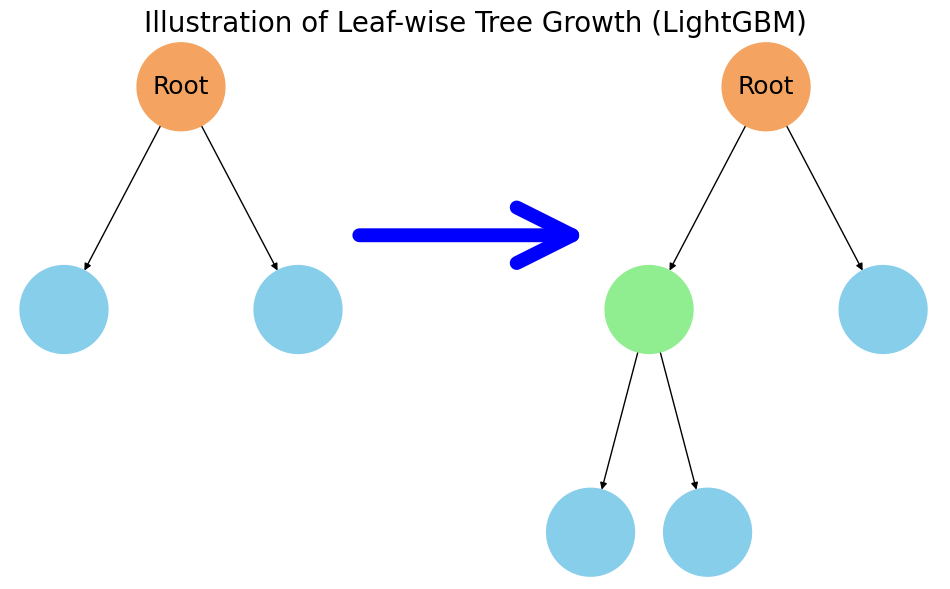

In [57]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch

# Create the first tree (simple tree)
G1 = nx.DiGraph()
G1.add_node(1, pos=(0.5, 1), color="sandybrown")
G1.add_node(2, pos=(0.3, 0.7))
G1.add_node(3, pos=(0.7, 0.7))
G1.add_edge(1, 2)
G1.add_edge(1, 3)

pos1 = nx.get_node_attributes(G1, 'pos')
node_colors_1 = ['sandybrown', 'skyblue', 'skyblue']

# Create the second tree (expanded on the most promising leaf nodes)
G2 = nx.DiGraph()
G2.add_node(1, pos=(1.5, 1), color="sandybrown")
G2.add_node(2, pos=(1.3, 0.7), color="lightgreen")
G2.add_node(3, pos=(1.7, 0.7))
G2.add_node(4, pos=(1.2, 0.4))
G2.add_node(5, pos=(1.4, 0.4))
G2.add_edges_from([(1, 2), (1, 3), (2, 4), (2, 5)])

pos2 = nx.get_node_attributes(G2, 'pos')
node_colors_2 = ['sandybrown', 'lightgreen', 'skyblue', 'skyblue', 'skyblue']

# Plot the combined trees
fig, ax = plt.subplots(figsize=(12, 7))

# Draw the first tree
nx.draw(G1, pos1, ax=ax, with_labels=False, node_color=node_colors_1, node_size=4000, edge_color="black")
nx.draw_networkx_labels(G1, pos1, labels={1: 'Root', 2: '', 3: ''},  font_color="black", font_size=18)

# Draw the second tree
nx.draw(G2, pos2, ax=ax, with_labels=False, node_color=node_colors_2, node_size=4000, edge_color="black")
nx.draw_networkx_labels(G2, pos2, labels={1: 'Root', 2: '', 3: '', 4: '', 5: ''},  font_color="black", font_size=18)

# Add an arrow between the trees
arrow = FancyArrowPatch((0.8, 0.8), (1.2, 0.8), mutation_scale=100, color="blue", linewidth=10, arrowstyle='->')
ax.add_patch(arrow)

# Set title and show plot
plt.title("Illustration of Leaf-wise Tree Growth (LightGBM)", fontsize=20)
plt.axis('off')
plt.show()


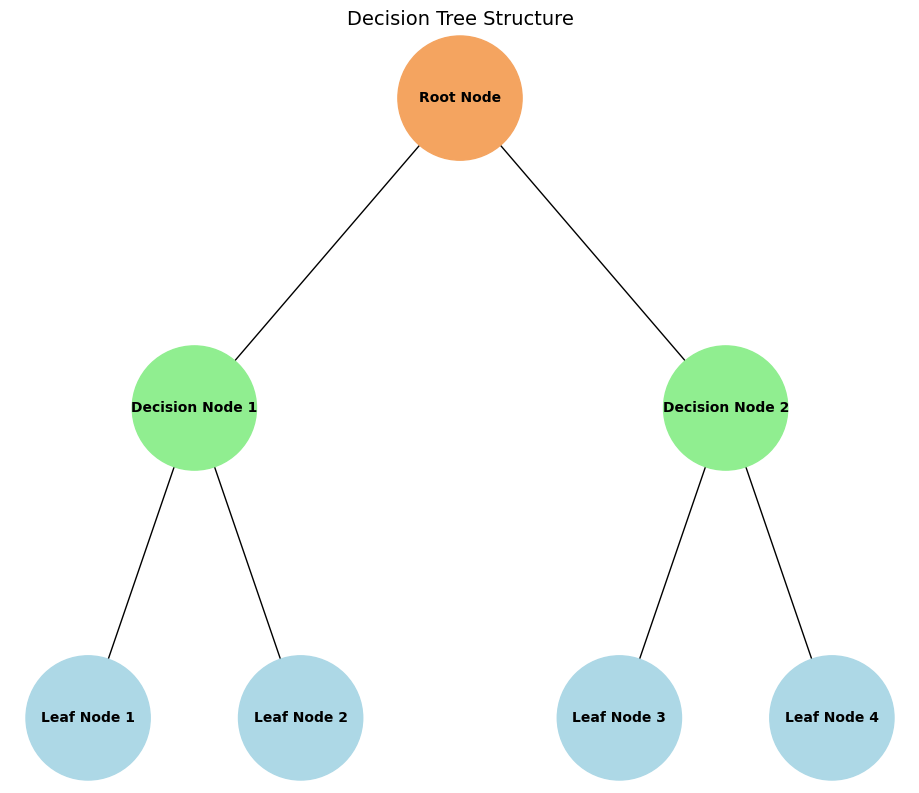

In [41]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges for a simple decision tree structure
# Root node
G.add_node("Root Node", color="sandybrown")

# Decision nodes
decision_nodes = ["Decision Node 1", "Decision Node 2"]
for node in decision_nodes:
    G.add_node(node, color="lightgreen")

# Leaf nodes
leaf_nodes = ["Leaf Node 1", "Leaf Node 2", "Leaf Node 3", "Leaf Node 4"]
for node in leaf_nodes:
    G.add_node(node, color="lightblue")

# Connect nodes to form the tree structure
G.add_edge("Root Node", "Decision Node 1")
G.add_edge("Root Node", "Decision Node 2")
G.add_edge("Decision Node 1", "Leaf Node 1")
G.add_edge("Decision Node 1", "Leaf Node 2")
G.add_edge("Decision Node 2", "Leaf Node 3")
G.add_edge("Decision Node 2", "Leaf Node 4")

# Define colors for the nodes based on their type
node_colors = [G.nodes[node].get("color", "skyblue") for node in G.nodes]

# Set up the layout
pos = {
    "Root Node": (0.5, 1.0),
    "Decision Node 1": (0.25, 0.9),
    "Decision Node 2": (0.75, 0.9),
    "Leaf Node 1": (0.15, 0.8),
    "Leaf Node 2": (0.35, 0.8),
    "Leaf Node 3": (0.65, 0.8),
    "Leaf Node 4": (0.85, 0.8)
}

# Plot the graph
plt.figure(figsize=(9, 7.5))
nx.draw(G, pos, with_labels=True, node_size=8000,  node_color=node_colors, font_size=10, font_weight="bold", arrows=False)
plt.title("Decision Tree Structure", fontsize=14)
plt.show()


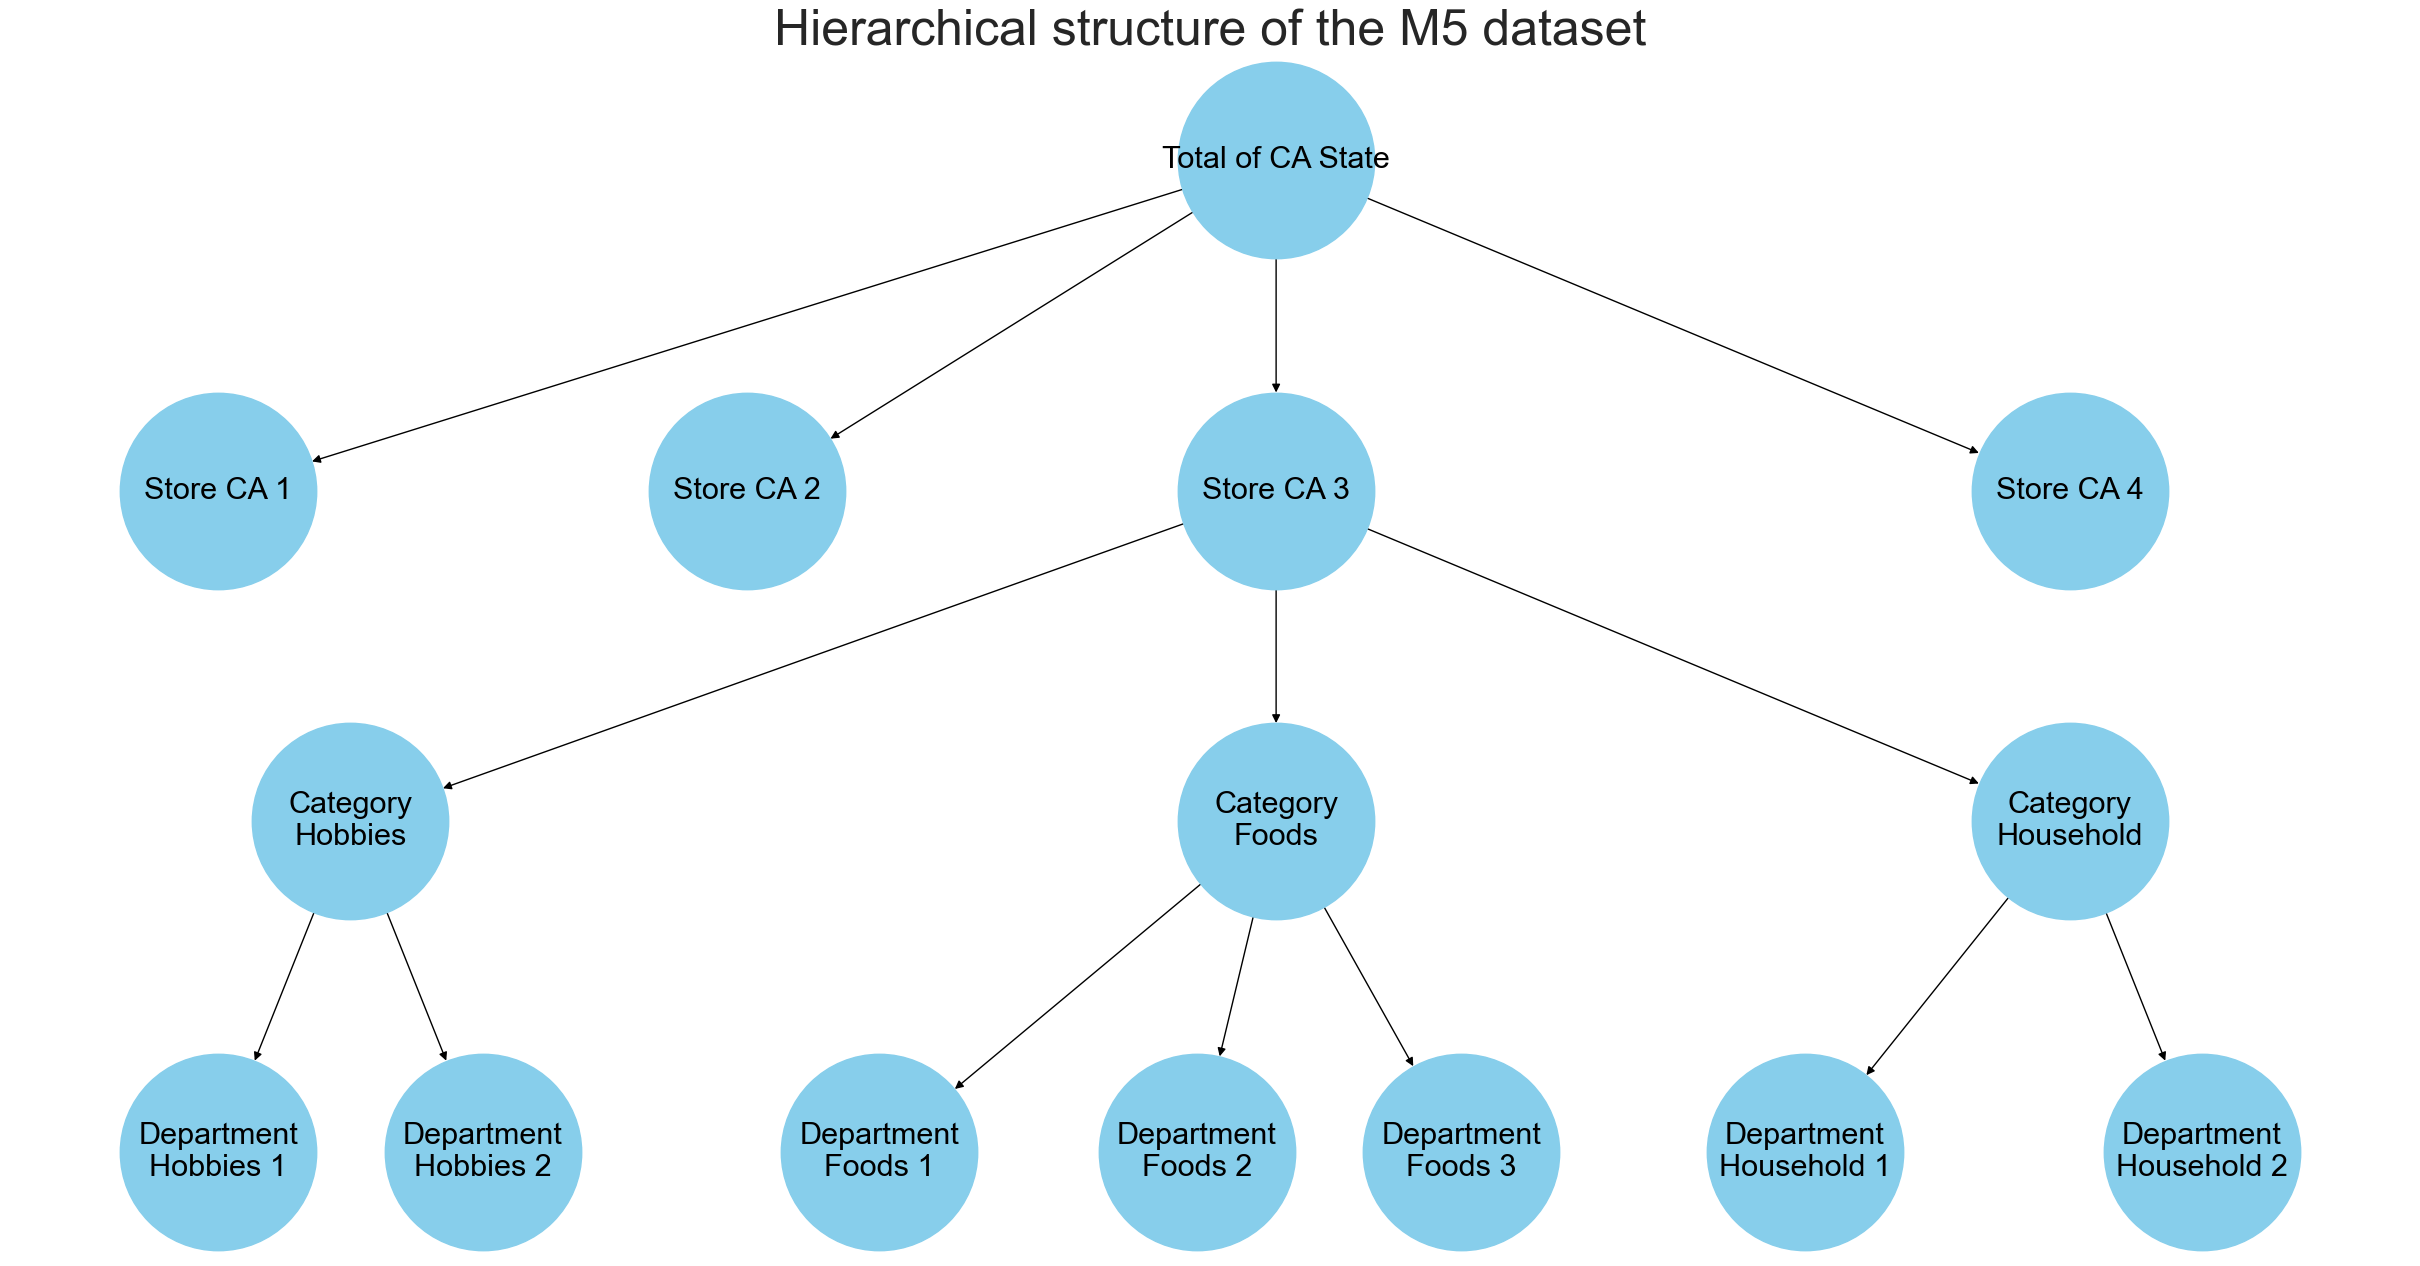

In [425]:
# Create the directed graph
G = nx.DiGraph()

# Add nodes and their connections
G.add_node("Country")
stores = ["Store CA 1", "Store CA 2", "Store CA 3", "Store CA 4"]
categories = ["Category\nHobbies", "Category\nFoods", "Category\nHousehold"]
departments = {
    "Category\nHobbies": ["Department\nHobbies 1", "Department\nHobbies 2"],
    "Category\nFoods": ["Department\nFoods 1", "Department\nFoods 2", "Department\nFoods 3"],
    "Category\nHousehold": ["Department\nHousehold 1", "Department\nHousehold 2"]
}

# Connect "Total of CA State" to each store
for store in stores:
    G.add_edge("Total of CA State", store)

# Connect only "Store CA 3" to categories
for category in categories:
    G.add_edge("Store CA 3", category)

# Connect each category to its departments
for category, deps in departments.items():
    for dep in deps:
        G.add_edge(category, dep)

# Manually set positions for a clear, structured layout
pos = {
    "Total of CA State": (4, 2),
    "Store CA 1": (0, 1), "Store CA 2": (2, 1), "Store CA 3": (4, 1), "Store CA 4": (7, 1),
    "Category\nHobbies": (0.5, 0), "Category\nFoods": (4, 0), "Category\nHousehold": (7, 0),
    "Department\nHobbies 1": (0, -1), "Department\nHobbies 2": (1, -1),
    "Department\nFoods 1": (2.5, -1), "Department\nFoods 2": (3.7, -1), "Department\nFoods 3": (4.7, -1),
    "Department\nHousehold 1": (6, -1), "Department\nHousehold 2": (7.5, -1)
}

# Draw the graph
plt.figure(figsize=(24, 12))
nx.draw(G, pos, with_labels=True, node_size=20000, node_color='skyblue', font_size=22, arrows=True, arrowstyle='-|>', arrowsize=12)
plt.title("Hierarchical structure of the M5 dataset", fontsize=36)
plt.axis('off')  # Turn off the axis to clean up the plot
plt.show()
